# First Models

## Data Preperation for Poisson Regression Model

### Loading

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime,timedelta
import pandas.api.types as ptypes

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import display

from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan

In [2]:
status_final = pd.read_csv(r"C:\Users\etaiw\Desktop\Projects\aviya_project\Data\Clean Data\Assign to Parking Lots Data\merged_parking_data_2023_2025.csv")
weather_original = pd.read_csv(r"C:\Users\etaiw\Desktop\Projects\aviya_project\Data\Clean Data\Final Weather\merged_weather_data_2023_2025.csv")

trips = status_final
weather = weather_original

In [3]:
print("STEP 0 - DataFrames loaded:")
print("trips shape:", trips.shape)
print("weather shape:", weather.shape)

STEP 0 - DataFrames loaded:
trips shape: (22827, 18)
weather shape: (3986, 13)


### STEP 1 - Prepare trips data at hourly resolution

In [4]:
# =========================================================
# STEP 1 - Prepare trips data at hourly resolution
# =========================================================

# 1.1 Ensure start_time is datetime
trips['start_time'] = pd.to_datetime(trips['start_time'], errors='coerce')

# 1.2 Keep only trip_start events (if the column exists)
if 'event_types' in trips.columns:
    trips_start_hr = trips[trips['event_types'] == 'trip_start'].copy()
else:
    trips_start_hr = trips.copy()

# 1.3 Floor to hour → this will be the time key for merging with weather
trips_start_hr['datetime_hour'] = trips_start_hr['start_time'].dt.floor('H')
trips_start_hr['date'] = trips_start_hr['datetime_hour'].dt.date
trips_start_hr['hour'] = trips_start_hr['datetime_hour'].dt.hour  # 0..23

print("\nSTEP 1 - trips_start_hr with datetime_hour/date/hour (sample):")
display(trips_start_hr[['start_time', 'datetime_hour', 'date', 'hour']].head())


STEP 1 - trips_start_hr with datetime_hour/date/hour (sample):


C:\Users\etaiw\AppData\Local\Temp\ipykernel_21796\3045977678.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  trips_start_hr['datetime_hour'] = trips_start_hr['start_time'].dt.floor('H')


start_time       datetime_hour        date  hour
2 2023-02-05 18:24:34 2023-02-05 18:00:00  2023-02-05    18
4 2023-02-08 17:46:06 2023-02-08 17:00:00  2023-02-08    17
6 2023-02-20 19:14:20 2023-02-20 19:00:00  2023-02-20    19
8 2023-02-01 16:23:19 2023-02-01 16:00:00  2023-02-01    16
9 2023-02-07 22:59:40 2023-02-07 22:00:00  2023-02-07    22

### STEP 2 - Aggregate trips to trips_per_hour (target y)

In [5]:
# =========================================================
# STEP 2A - Prepare hourly weather from raw weather_original
# =========================================================

# Start from the original clean weather dataframe
weather = weather_original.copy()

# Make sure 'datetime' is really datetime dtype
weather['datetime'] = pd.to_datetime(weather['datetime'], errors='coerce')

# Floor to hour resolution
weather['datetime_hour'] = weather['datetime'].dt.floor('H')

# Aggregate to hourly weather
hourly_weather = (
    weather
      .groupby('datetime_hour')
      .agg(
          temp_c      = ('temp_c', 'mean'),
          temp_max_c  = ('temp_max_c', 'mean'),
          temp_min_c  = ('temp_min_c', 'mean'),
          wind_speed_ms = ('wind_speed_ms', 'mean'),
          rain_mm     = ('rain_mm', 'sum'),
      )
      .reset_index()
)

print("\nSTEP 2A - hourly_weather (first rows):")
display(hourly_weather.head())
print("\nSTEP 2A - hourly_weather shape:", hourly_weather.shape)



STEP 2A - hourly_weather (first rows):


C:\Users\etaiw\AppData\Local\Temp\ipykernel_21796\2694457965.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather['datetime_hour'] = weather['datetime'].dt.floor('H')


datetime_hour     temp_c  temp_max_c  temp_min_c  wind_speed_ms  \
0 2023-02-01 00:00:00  14.233333       15.15       13.25      10.316667   
1 2023-02-01 01:00:00  15.266667       15.65       14.75      11.383333   
2 2023-02-01 02:00:00  15.366667       15.60       15.00      10.216667   
3 2023-02-01 03:00:00  14.450000       15.20       13.95       5.983333   
4 2023-02-01 04:00:00  16.016667       16.15       15.55       8.266667   

   rain_mm  
0      3.5  
1      0.6  
2      0.0  
3      0.0  
4      0.0


STEP 2A - hourly_weather shape: (1994, 6)


In [6]:
# =========================================================
# STEP 2B - Aggregate trips to trips_per_hour (target y)
# =========================================================

hourly_trips = (
    trips_start_hr
    .groupby('datetime_hour')
    .size()
    .rename('trips_per_hour')
    .reset_index()
)

print("\nSTEP 2B - hourly_trips (first rows):")
display(hourly_trips.head())

print("\nSTEP 2B - hourly_trips shape:", hourly_trips.shape)
print("\nSTEP 2B - trips_per_hour summary:")
display(hourly_trips['trips_per_hour'].describe().to_frame(name='trips_per_hour_stats'))



STEP 2B - hourly_trips (first rows):


datetime_hour  trips_per_hour
0 2023-02-01 00:00:00               1
1 2023-02-01 08:00:00               1
2 2023-02-01 09:00:00               2
3 2023-02-01 10:00:00               2
4 2023-02-01 11:00:00               3


STEP 2B - hourly_trips shape: (1536, 2)

STEP 2B - trips_per_hour summary:


trips_per_hour_stats
count           1536.000000
mean               6.250000
std                5.481387
min                1.000000
25%                2.000000
50%                5.000000
75%                9.000000
max               35.000000

### STEP 3 - Build full hourly panel and merge trips (with interpolation time based)
Interpolation = fills missing or intermediate values by estimating them from surrounding data points

In [7]:
# =========================================================
# STEP 3 - Build full hourly panel and merge trips (with interpolation)
# =========================================================

from IPython.display import display

# 3.1 Define full hourly range based on weather datetime_hour
start_hour = weather['datetime_hour'].min().floor('H')
end_hour   = weather['datetime_hour'].max().ceil('H')

full_hours = pd.date_range(start=start_hour, end=end_hour, freq='H')
reg_hourly = pd.DataFrame({'datetime_hour': full_hours})

print("\nSTEP 3 - full_hours created:")
print(reg_hourly.shape)
display(reg_hourly.head(10))

# 3.2 Merge hourly trips (NaN → 0 trips)
reg_hourly = reg_hourly.merge(hourly_trips, on='datetime_hour', how='left')
reg_hourly['trips_per_hour'] = reg_hourly['trips_per_hour'].fillna(0).astype(int)

# 3.3 Merge hourly weather (NaNs to be interpolated)
reg_hourly = reg_hourly.merge(hourly_weather, on='datetime_hour', how='left')

print("\nSTEP 3 - before interpolation (check NaNs):")
display(reg_hourly.isna().sum().to_frame('n_missing'))

# 3.4 Interpolate missing weather columns over time
reg_hourly = reg_hourly.sort_values('datetime_hour').set_index('datetime_hour')
weather_cols = ['temp_c', 'temp_max_c', 'temp_min_c', 'wind_speed_ms', 'rain_mm']

reg_hourly[weather_cols] = reg_hourly[weather_cols].interpolate(
    method='time',
    limit_direction='both'
)

# 3.5 Back to normal index and sanity check for hourly gaps
reg_hourly = reg_hourly.reset_index()

print("\nSTEP 3 - after interpolation (check gaps):")
reg_hourly['delta'] = reg_hourly['datetime_hour'].diff().dt.total_seconds() / 3600
print(reg_hourly['delta'].value_counts().head(10))

print("\nSTEP 3 - Sample of datetime_hour + trips_per_hour:")
display(reg_hourly[['datetime_hour', 'trips_per_hour']].head(24))



STEP 3 - full_hours created:
(18193, 1)


C:\Users\etaiw\AppData\Local\Temp\ipykernel_21796\2466237866.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_hour = weather['datetime_hour'].min().floor('H')
C:\Users\etaiw\AppData\Local\Temp\ipykernel_21796\2466237866.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end_hour   = weather['datetime_hour'].max().ceil('H')
C:\Users\etaiw\AppData\Local\Temp\ipykernel_21796\2466237866.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_hours = pd.date_range(start=start_hour, end=end_hour, freq='H')


datetime_hour
0 2023-02-01 00:00:00
1 2023-02-01 01:00:00
2 2023-02-01 02:00:00
3 2023-02-01 03:00:00
4 2023-02-01 04:00:00
5 2023-02-01 05:00:00
6 2023-02-01 06:00:00
7 2023-02-01 07:00:00
8 2023-02-01 08:00:00
9 2023-02-01 09:00:00


STEP 3 - before interpolation (check NaNs):


n_missing
datetime_hour           0
trips_per_hour          0
temp_c              16199
temp_max_c          16199
temp_min_c          16199
wind_speed_ms       16199
rain_mm             16199


STEP 3 - after interpolation (check gaps):
delta
1.0    18192
Name: count, dtype: int64

STEP 3 - Sample of datetime_hour + trips_per_hour:


datetime_hour  trips_per_hour
0  2023-02-01 00:00:00               1
1  2023-02-01 01:00:00               0
2  2023-02-01 02:00:00               0
3  2023-02-01 03:00:00               0
4  2023-02-01 04:00:00               0
5  2023-02-01 05:00:00               0
6  2023-02-01 06:00:00               0
7  2023-02-01 07:00:00               0
8  2023-02-01 08:00:00               1
9  2023-02-01 09:00:00               2
10 2023-02-01 10:00:00               2
11 2023-02-01 11:00:00               3
12 2023-02-01 12:00:00               5
13 2023-02-01 13:00:00               3
14 2023-02-01 14:00:00               4
15 2023-02-01 15:00:00               6
16 2023-02-01 16:00:00              11
17 2023-02-01 17:00:00               3
18 2023-02-01 18:00:00               5
19 2023-02-01 19:00:00               9
20 2023-02-01 20:00:00               8
21 2023-02-01 21:00:00               3
22 2023-02-01 22:00:00               2
23 2023-02-01 23:00:00               1

### STEP 4 - Add weekday (int), weekday_name, weekend (0/1)

In [8]:
# =========================================================
# STEP 4 - Add weekday (Sunday=0), weekend, weekday_name
# =========================================================

# Python weekday: Monday=0, Sunday=6
python_weekday_hr = reg_hourly['datetime_hour'].dt.weekday

# Custom weekday: Sunday=0, Monday=1, ..., Saturday=6
reg_hourly['weekday'] = (python_weekday_hr + 1) % 7

# Weekend in Israel: Friday (5) and Saturday (6) in this coding
reg_hourly['is_weekend'] = reg_hourly['weekday'].isin([5, 6]).astype(int)

# Human-readable weekday name
reg_hourly['weekday_name'] = reg_hourly['datetime_hour'].dt.day_name()

print("\nSTEP 4 - weekday (Sunday=0), is_weekend, weekday_name (sample):")
display(reg_hourly[['datetime_hour', 'weekday', 'weekday_name', 'is_weekend']].head())



STEP 4 - weekday (Sunday=0), is_weekend, weekday_name (sample):


datetime_hour  weekday weekday_name  is_weekend
0 2023-02-01 00:00:00        3    Wednesday           0
1 2023-02-01 01:00:00        3    Wednesday           0
2 2023-02-01 02:00:00        3    Wednesday           0
3 2023-02-01 03:00:00        3    Wednesday           0
4 2023-02-01 04:00:00        3    Wednesday           0

### STEP 5 - Define flexible time-of-day segments
#### Update HERE for different time slots

In [9]:
# =========================================================
# STEP 5 - Create time-of-day segments and dummies
# =========================================================

from IPython.display import display

# 5.0 Make sure 'hour' column exists
if 'hour' not in reg_hourly.columns:
    reg_hourly['hour'] = reg_hourly['datetime_hour'].dt.hour

print("STEP 5 - Hour column check:")
print(reg_hourly[['datetime_hour', 'hour']].head())

# 5.1 Remove old TOD columns if they exist
cols_to_drop = [c for c in reg_hourly.columns if c.startswith('tod_')] + ['tod_segment']
if cols_to_drop:
    reg_hourly = reg_hourly.drop(columns=cols_to_drop, errors='ignore')

# 5.2 Define logical time-of-day mapping
# Night is one continuous logical category: 20:00–24:00 AND 00:00–07:00
def map_tod(hour):
    # night: 20:00–24:00 or 00:00–07:00
    if (hour >= 20) or (hour < 7):
        return 'night'
    # morning: 07:00–10:00
    elif 7 <= hour < 10:
        return 'morning'
    # afternoon (day): 10:00–16:00
    elif 10 <= hour < 16:
        return 'afternoon'
    # evening: 16:00–20:00
    else:  # 16 <= hour < 20
        return 'evening'

reg_hourly['tod_segment'] = reg_hourly['hour'].apply(map_tod)

# 5.3 Ensure categorical type with explicit order so that
# 'night' is the baseline when we create dummies (drop_first=True)
tod_cat_type = pd.api.types.CategoricalDtype(
    categories=['night', 'morning', 'afternoon', 'evening'],
    ordered=True
)
reg_hourly['tod_segment'] = reg_hourly['tod_segment'].astype(tod_cat_type)

print("\nSTEP 5 - tod_segment created (night = 20:00–07:00):")
display(reg_hourly[['datetime_hour', 'hour', 'tod_segment']].head())


STEP 5 - Hour column check:
        datetime_hour  hour
0 2023-02-01 00:00:00     0
1 2023-02-01 01:00:00     1
2 2023-02-01 02:00:00     2
3 2023-02-01 03:00:00     3
4 2023-02-01 04:00:00     4

STEP 5 - tod_segment created (night = 20:00–07:00):


datetime_hour  hour tod_segment
0 2023-02-01 00:00:00     0       night
1 2023-02-01 01:00:00     1       night
2 2023-02-01 02:00:00     2       night
3 2023-02-01 03:00:00     3       night
4 2023-02-01 04:00:00     4       night

### STEP 6 - Create dummy variables for weekday and TOD segments

#### 6.0 - Create weekday dummy variables

In [10]:
# =========================================================
# STEP 6.0 - Choose subset for modeling and create weekday dummies
# =========================================================
# weekday coding in this notebook: Sunday=0 ... Saturday=6

MODE_FOR_MAIN_MODEL = "weekdays"  # options: "all", "weekdays", "weekends"

def subset_by_mode(df, mode):
    if mode == "all":
        return df.copy()
    if mode == "weekdays":
        return df[df["weekday"].isin([0, 1, 2, 3, 4])].copy()   # Sun–Thu
    if mode == "weekends":
        return df[df["weekday"].isin([5, 6])].copy()           # Fri–Sat
    raise ValueError("mode must be one of: all, weekdays, weekends")

reg_model = subset_by_mode(reg_hourly, MODE_FOR_MAIN_MODEL).copy()
reg_model["hour"] = reg_model["datetime_hour"].dt.hour

# Keep reg_wd as an alias so downstream cells that expect reg_wd won't break
reg_wd = reg_model

# Weekday dummies (Sunday baseline via drop_first)
wd_dummy_cols = pd.get_dummies(reg_model["weekday"], prefix="wd", drop_first=True)

print("MODE_FOR_MAIN_MODEL:", MODE_FOR_MAIN_MODEL)
print("reg_model shape:", reg_model.shape)
print("wd_dummy_cols shape:", wd_dummy_cols.shape)
display(wd_dummy_cols.head())


MODE_FOR_MAIN_MODEL: weekdays
reg_model shape: (13008, 13)
wd_dummy_cols shape: (13008, 4)


wd_1   wd_2  wd_3   wd_4
0  False  False  True  False
1  False  False  True  False
2  False  False  True  False
3  False  False  True  False
4  False  False  True  False

#### 6.1 - Create TOD (Time Of Day Segment) dummy variables

In [11]:
# =========================================================
# STEP 6.1 - Create TOD (Time Of Day Segment) dummy variables (BASELINE)
# =========================================================
# 4-bin TOD scheme (edit cutoffs if you used different ones in your thesis)
reg_model["tod_segment"] = pd.cut(
    reg_model["hour"],
    bins=[-1, 5, 11, 17, 23],
    labels=["night", "morning", "afternoon", "evening"]
)

tod_dummy_cols = pd.get_dummies(reg_model["tod_segment"], prefix="tod", drop_first=True)

print("TOD dummy columns created:", tod_dummy_cols.columns.tolist())
print("tod_dummy_cols shape:", tod_dummy_cols.shape)
display(tod_dummy_cols.head())


TOD dummy columns created: ['tod_morning', 'tod_afternoon', 'tod_evening']
tod_dummy_cols shape: (13008, 3)


tod_morning  tod_afternoon  tod_evening
0        False          False        False
1        False          False        False
2        False          False        False
3        False          False        False
4        False          False        False

#### 6.2 - Build feature list (X&Y)

In [12]:
# =========================================================
# STEP 6.2 - Build feature matrices (X) and target (y)
# =========================================================

# Choose weather columns that exist in your panel
weather_cols = [c for c in ["temp_c", "rain_mm", "wind_speed_ms"] if c in reg_model.columns]
print("Weather columns used:", weather_cols)

y_hr = reg_model["trips_per_hour"]

# Baseline X: TOD + weekday + weather
X_baseline = pd.concat([tod_dummy_cols, wd_dummy_cols, reg_model[weather_cols]], axis=1)
X_baseline = sm.add_constant(X_baseline, has_constant="add")

# Optimized X: Hour fixed effects + weekday + weather
hour_dummy_cols = pd.get_dummies(reg_model["hour"], prefix="hour", drop_first=True)
X_hourFE = pd.concat([hour_dummy_cols, wd_dummy_cols, reg_model[weather_cols]], axis=1)
X_hourFE = sm.add_constant(X_hourFE, has_constant="add")

print("X_baseline shape:", X_baseline.shape)
print("X_hourFE shape:", X_hourFE.shape)
print("y_hr shape:", y_hr.shape)


Weather columns used: ['temp_c', 'rain_mm', 'wind_speed_ms']
X_baseline shape: (13008, 11)
X_hourFE shape: (13008, 31)
y_hr shape: (13008,)


#### 6.3 - FIX v2: Clean features (drop non-numeric / all-NaN columns)

In [13]:
# =========================================================
# STEP 6.3 - Clean features (force numeric, fill NaNs)
# =========================================================

def clean_X(X: pd.DataFrame) -> pd.DataFrame:
    Xc = X.copy()
    Xc = Xc.apply(pd.to_numeric, errors="coerce")
    Xc = Xc.fillna(0)
    return Xc.astype(float)

X_baseline_clean = clean_X(X_baseline)
X_hourFE_clean   = clean_X(X_hourFE)

# Keep names used later in the notebook
X_hr = X_hourFE_clean

print("Cleaned shapes:")
print("X_baseline_clean:", X_baseline_clean.shape)
print("X_hourFE_clean:", X_hourFE_clean.shape)
display(X_hourFE_clean.head())


Cleaned shapes:
X_baseline_clean: (13008, 11)
X_hourFE_clean: (13008, 31)


const  hour_1  hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  hour_8  \
0    1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1    1.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2    1.0     0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0   
3    1.0     0.0     0.0     1.0     0.0     0.0     0.0     0.0     0.0   
4    1.0     0.0     0.0     0.0     1.0     0.0     0.0     0.0     0.0   

   hour_9  ...  hour_21  hour_22  hour_23  wd_1  wd_2  wd_3  wd_4     temp_c  \
0     0.0  ...      0.0      0.0      0.0   0.0   0.0   1.0   0.0  14.233333   
1     0.0  ...      0.0      0.0      0.0   0.0   0.0   1.0   0.0  15.266667   
2     0.0  ...      0.0      0.0      0.0   0.0   0.0   1.0   0.0  15.366667   
3     0.0  ...      0.0      0.0      0.0   0.0   0.0   1.0   0.0  14.450000   
4     0.0  ...      0.0      0.0      0.0   0.0   0.0   1.0   0.0  16.016667   

   rain_mm  wind_speed_ms  
0      3.5      10.316667  
1      0.6      11.383333  
2      0.0      10.216667  
3      0.0       5.983333  
4      0.0       8.266667  

[5 rows x 31 columns]

## Poisson Models

#### STEP 7 - Fit Poisson models (Baseline vs Hour-FE) + diagnostics


In [14]:
# =========================================================
# STEP 7 - Fit Poisson models (Baseline vs Hour-FE) + diagnostics
# =========================================================

# Baseline Poisson (TOD)
poisson_baseline = sm.GLM(y_hr, X_baseline_clean, family=sm.families.Poisson()).fit()
disp_baseline = (poisson_baseline.resid_pearson**2).sum() / poisson_baseline.df_resid

print("BASELINE (TOD) Poisson")
print(poisson_baseline.summary().tables[0])
print(f"Dispersion (Pearson Chi2 / df_resid): {disp_baseline:.3f}")

# Optimized Poisson (Hour fixed effects)
poisson_hr_results = sm.GLM(y_hr, X_hourFE_clean, family=sm.families.Poisson()).fit()
disp_hourFE = (poisson_hr_results.resid_pearson**2).sum() / poisson_hr_results.df_resid

print("\nOPTIMIZED (Hour-FE) Poisson")
print(poisson_hr_results.summary().tables[0])
print(f"Dispersion (Pearson Chi2 / df_resid): {disp_hourFE:.3f}")

# Robust SE for optimized model (same coefficients, safer inference)
poisson_hr_results_robust = sm.GLM(y_hr, X_hourFE_clean, family=sm.families.Poisson()).fit(cov_type="HC0")
print("\nOPTIMIZED (Hour-FE) Poisson with Robust SE (HC0)")
print(poisson_hr_results_robust.summary().tables[0])

# Keep a single reference used later
dispersion_main = disp_hourFE


BASELINE (TOD) Poisson
                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                13008
Model:                            GLM   Df Residuals:                    12997
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21797.
Date:                Tue, 13 Jan 2026   Deviance:                       39690.
Time:                        02:33:07   Pearson chi2:                 1.10e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3192
Covariance Type:            nonrobust                                         
Dispersion (Pearson Chi2 / df_resid): 8.484



OPTIMIZED (Hour-FE) Poisson
                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                13008
Model:                            GLM   Df Residuals:                    12977
Model Family:                 Poisson   Df Model:                           30
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20673.
Date:                Tue, 13 Jan 2026   Deviance:                       37442.
Time:                        02:33:08   Pearson chi2:                 8.58e+04
No. Iterations:                     8   Pseudo R-squ. (CS):             0.4273
Covariance Type:            nonrobust                                         
Dispersion (Pearson Chi2 / df_resid): 6.612

OPTIMIZED (Hour-FE) Poisson with Robust SE (HC0)
                 Generalized Linear Model Regression Results                  
Dep. Var

#### STEP 7b - 3-way comparison (All vs Weekdays vs Weekends) using Optimized Poisson


In [15]:
# =========================================================
# STEP 7b - 3-way comparison (All vs Weekdays vs Weekends) using Optimized Poisson
# =========================================================

modes = ["all", "weekdays", "weekends"]
results = {}

for mode in modes:
    dfm = subset_by_mode(reg_hourly, mode).copy()
    dfm["hour"] = dfm["datetime_hour"].dt.hour

    hour_dummies = pd.get_dummies(dfm["hour"], prefix="hour", drop_first=True)
    wd_dummies   = pd.get_dummies(dfm["weekday"], prefix="wd", drop_first=True)
    weather_cols = [c for c in ["temp_c", "rain_mm", "wind_speed_ms"] if c in dfm.columns]

    X = pd.concat([hour_dummies, wd_dummies, dfm[weather_cols]], axis=1)
    X = sm.add_constant(X, has_constant="add")
    X = clean_X(X)
    y = dfm["trips_per_hour"]

    res = sm.GLM(y, X, family=sm.families.Poisson()).fit(cov_type="HC0")
    disp = (res.resid_pearson**2).sum() / res.df_resid

    results[mode] = {"n": len(dfm), "dispersion": float(disp), "res": res}

summary_df = pd.DataFrame({m: {"n": results[m]["n"], "dispersion": results[m]["dispersion"]} for m in modes}).T
summary_df


n  dispersion
all       18193.0    7.002411
weekdays  13008.0    6.612292
weekends   5185.0    4.417197

## STEP 8 — Model Diagnostics & Visualization (Poisson)

#### STEP 8.0 — Setup helpers (paste as one cell)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

# --- safety checks ---
required_cols = ["datetime_hour", "trips_per_hour", "weekday"]
for c in required_cols:
    if c not in reg_hourly.columns:
        raise KeyError(f"reg_hourly is missing column: {c}")

def subset_by_mode(df, mode):
    """
    mode options:
      - "all": Sun–Sat
      - "weekdays": Sun–Thu (weekday in {0,1,2,3,4} where Sunday=0)
      - "weekends": Fri–Sat (weekday in {5,6})
    """
    if mode == "all":
        return df.copy()
    if mode == "weekdays":
        return df[df["weekday"].isin([0,1,2,3,4])].copy()
    if mode == "weekends":
        return df[df["weekday"].isin([5,6])].copy()
    raise ValueError("mode must be one of: all, weekdays, weekends")

def clean_X(X: pd.DataFrame) -> pd.DataFrame:
    return X.apply(pd.to_numeric, errors="coerce").fillna(0).astype(float)

def build_hourFE_design(dfm: pd.DataFrame):
    """
    Builds the same X used in the optimized Poisson:
    hour fixed effects + weekday dummies + weather.
    Returns (X, y, dfm_with_hour)
    """
    dfm = dfm.copy()
    dfm["hour"] = dfm["datetime_hour"].dt.hour

    hour_dummies = pd.get_dummies(dfm["hour"], prefix="hour", drop_first=True)
    wd_dummies   = pd.get_dummies(dfm["weekday"], prefix="wd", drop_first=True)

    weather_cols = [c for c in ["temp_c", "rain_mm", "wind_speed_ms"] if c in dfm.columns]

    X = pd.concat([hour_dummies, wd_dummies, dfm[weather_cols]], axis=1)
    X = sm.add_constant(X, has_constant="add")
    X = clean_X(X)

    y = dfm["trips_per_hour"].astype(int)
    return X, y, dfm

def fit_poisson_hourFE(dfm: pd.DataFrame, robust=True):
    X, y, dfm2 = build_hourFE_design(dfm)
    if robust:
        res = sm.GLM(y, X, family=sm.families.Poisson()).fit(cov_type="HC0")
    else:
        res = sm.GLM(y, X, family=sm.families.Poisson()).fit()
    return res, X, y, dfm2

def dispersion(res):
    pearson_chi2 = float(np.sum(res.resid_pearson ** 2))
    return pearson_chi2 / float(res.df_resid)

# Choose what you want to visualize here:
STEP8_MODE = "weekdays"   # "all" / "weekdays" / "weekends"

df_plot = subset_by_mode(reg_hourly, STEP8_MODE)
res_plot, X_plot, y_plot, df_plot = fit_poisson_hourFE(df_plot, robust=True)

print("STEP8_MODE:", STEP8_MODE)
print("n:", len(df_plot), "| dispersion:", round(dispersion(res_plot), 3))


STEP8_MODE: weekdays
n: 13008 | dispersion: 6.612


#### STEP 8.1 — Observed vs Fitted (scatter)

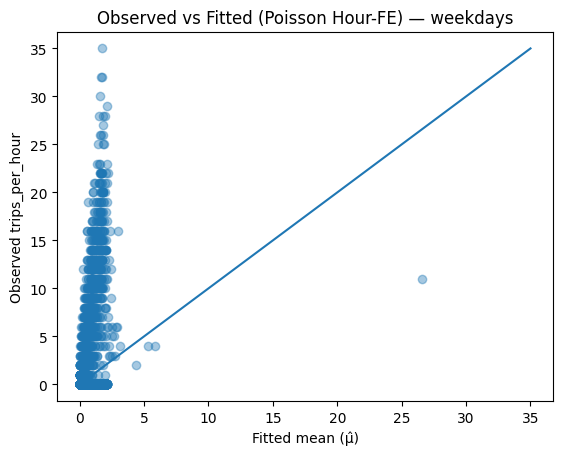

In [17]:
mu_hat = res_plot.fittedvalues  # predicted mean (Poisson)
y_obs = y_plot.values

plt.figure()
plt.scatter(mu_hat, y_obs, alpha=0.4)
plt.xlabel("Fitted mean (μ̂)")
plt.ylabel("Observed trips_per_hour")
plt.title(f"Observed vs Fitted (Poisson Hour-FE) — {STEP8_MODE}")

# 45-degree reference line
mx = max(mu_hat.max(), y_obs.max())
plt.plot([0, mx], [0, mx])
plt.show()


#### STEP 8.2 — Pearson residuals vs fitted

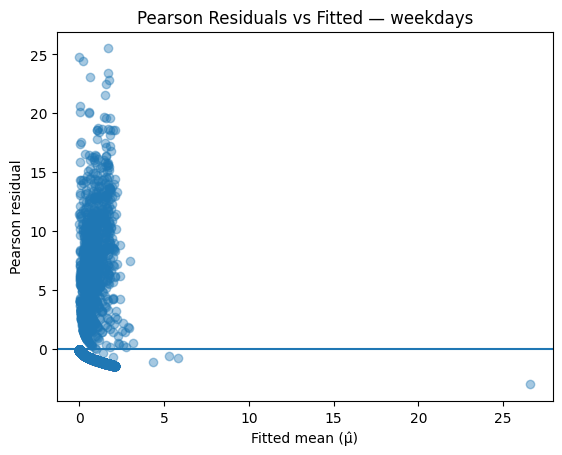

In [18]:
mu_hat = res_plot.fittedvalues
pearson_resid = res_plot.resid_pearson

plt.figure()
plt.scatter(mu_hat, pearson_resid, alpha=0.4)
plt.axhline(0)
plt.xlabel("Fitted mean (μ̂)")
plt.ylabel("Pearson residual")
plt.title(f"Pearson Residuals vs Fitted — {STEP8_MODE}")
plt.show()


#### STEP 8.4 — Compare distributions: Weekdays vs Weekends (hist + ECDF + KS test)

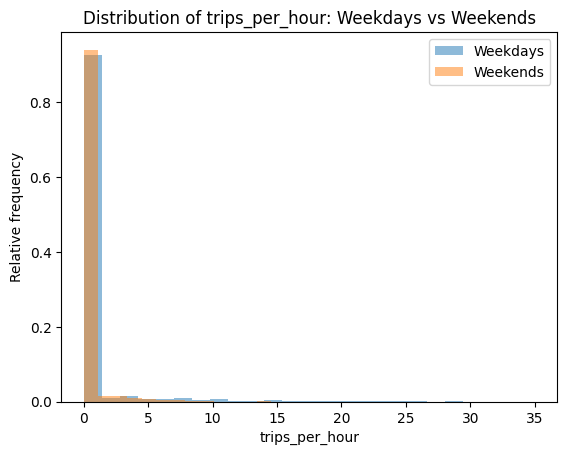

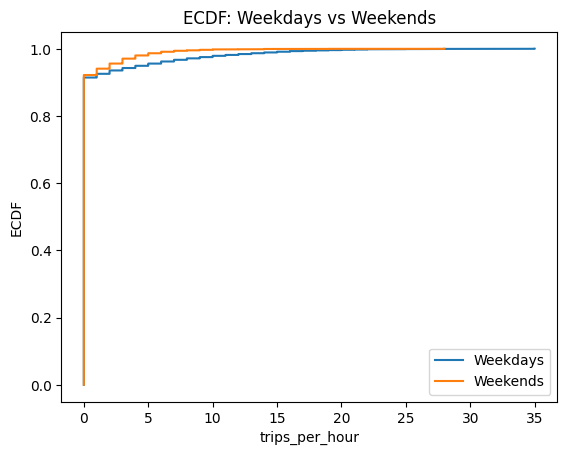

KS test Weekdays vs Weekends:
  statistic: 0.0307961364329169
  p-value: 0.0017295350640868493


In [19]:
df_wd = subset_by_mode(reg_hourly, "weekdays").copy()
df_we = subset_by_mode(reg_hourly, "weekends").copy()

y_wd = df_wd["trips_per_hour"].values
y_we = df_we["trips_per_hour"].values

# Histogram (density-ish via weights)
plt.figure()
plt.hist(y_wd, bins=25, alpha=0.5, weights=np.ones_like(y_wd)/len(y_wd), label="Weekdays")
plt.hist(y_we, bins=25, alpha=0.5, weights=np.ones_like(y_we)/len(y_we), label="Weekends")
plt.xlabel("trips_per_hour")
plt.ylabel("Relative frequency")
plt.title("Distribution of trips_per_hour: Weekdays vs Weekends")
plt.legend()
plt.show()

# ECDF
def ecdf(a):
    a = np.sort(a)
    y = np.arange(1, len(a)+1) / len(a)
    return a, y

x1, y1 = ecdf(y_wd)
x2, y2 = ecdf(y_we)

plt.figure()
plt.step(x1, y1, where="post", label="Weekdays")
plt.step(x2, y2, where="post", label="Weekends")
plt.xlabel("trips_per_hour")
plt.ylabel("ECDF")
plt.title("ECDF: Weekdays vs Weekends")
plt.legend()
plt.show()

# KS test
ks = stats.ks_2samp(y_wd, y_we, alternative="two-sided", mode="auto")
print("KS test Weekdays vs Weekends:")
print("  statistic:", ks.statistic)
print("  p-value:", ks.pvalue)



#### STEP 8.5 — “Active hours” diagnostic (fixes your hour_true KeyError) overdispersion checking

Active-hours sample size: 5962
Zero rate in active hours (%): 88.76216034887622
Active-hours dispersion: 10.868


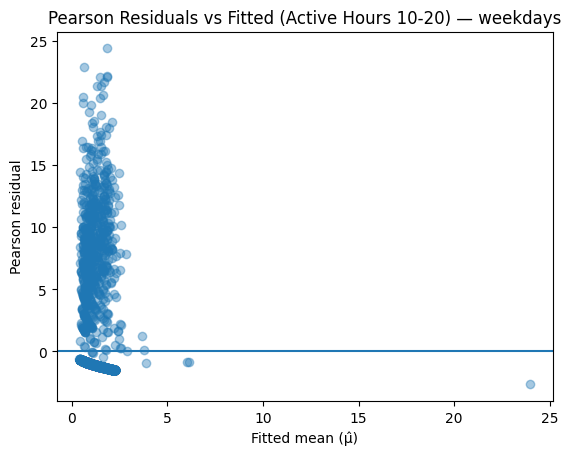

In [20]:
df_active = df_plot.copy()
df_active["hour"] = df_active["datetime_hour"].dt.hour

ACTIVE_START = 10
ACTIVE_END = 20

reg_active = df_active[df_active["hour"].between(ACTIVE_START, ACTIVE_END)].copy()

print("Active-hours sample size:", reg_active.shape[0])
print("Zero rate in active hours (%):", (reg_active["trips_per_hour"] == 0).mean() * 100)

# Fit Poisson on active hours (same spec)
res_active, X_active, y_active, reg_active = fit_poisson_hourFE(reg_active, robust=True)
print("Active-hours dispersion:", round(dispersion(res_active), 3))

# Plot residuals vs fitted in active hours
mu_hat = res_active.fittedvalues
pearson_resid = res_active.resid_pearson

plt.figure()
plt.scatter(mu_hat, pearson_resid, alpha=0.4)
plt.axhline(0)
plt.xlabel("Fitted mean (μ̂)")
plt.ylabel("Pearson residual")
plt.title(f"Pearson Residuals vs Fitted (Active Hours {ACTIVE_START}-{ACTIVE_END}) — {STEP8_MODE}")
plt.show()


#### STEP 8.6 – KS test: Friday vs Saturday

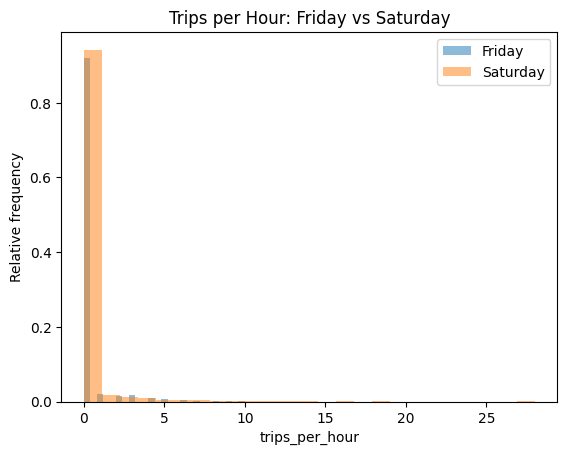

KS test Friday vs Saturday
Statistic: 0.005383231444582518
p-value: 0.9999999999993917


In [21]:
# =========================================================
# STEP 8.6 – KS test: Friday vs Saturday
# =========================================================

df_fri = reg_hourly[reg_hourly["weekday"] == 5]["trips_per_hour"].values
df_sat = reg_hourly[reg_hourly["weekday"] == 6]["trips_per_hour"].values

# Histograms
plt.figure()
plt.hist(df_fri, bins=25, alpha=0.5, weights=np.ones_like(df_fri)/len(df_fri), label="Friday")
plt.hist(df_sat, bins=25, alpha=0.5, weights=np.ones_like(df_sat)/len(df_sat), label="Saturday")
plt.xlabel("trips_per_hour")
plt.ylabel("Relative frequency")
plt.title("Trips per Hour: Friday vs Saturday")
plt.legend()
plt.show()

# KS test
ks_fs = stats.ks_2samp(df_fri, df_sat)
print("KS test Friday vs Saturday")
print("Statistic:", ks_fs.statistic)
print("p-value:", ks_fs.pvalue)


# New Models

## Modular Model

### Loading

In [22]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

from scipy.stats import norm
from IPython.display import display

In [23]:
# Load your datasets (edit paths as needed)
events_df = pd.read_csv(r"C:\Users\etaiw\Desktop\Projects\aviya_project\Data\Clean Data\Assign to Parking Lots Data\merged_parking_data_2023_2025.csv")     # scooter events dataset
weather_df = pd.read_csv(r"C:\Users\etaiw\Desktop\Projects\aviya_project\Data\Clean Data\Final Weather\merged_weather_data_2023_2025.csv")

### pre-process: 

#### Parse datetimes + create hourly keys

In [24]:
# ----------------------------
# Parse datetimes
# ----------------------------
events_df["start_time"] = pd.to_datetime(events_df["start_time"], errors="coerce")
weather_df["datetime"] = pd.to_datetime(weather_df["datetime"], errors="coerce")

# Drop rows with missing timestamps (critical)
events_df = events_df.dropna(subset=["start_time"]).copy()
weather_df = weather_df.dropna(subset=["datetime"]).copy()

# ----------------------------
# Create hourly keys
# ----------------------------
events_df["datetime_hour"] = events_df["start_time"].dt.floor("H")
weather_df["datetime_hour"] = weather_df["datetime"].dt.floor("H")


C:\Users\etaiw\AppData\Local\Temp\ipykernel_21796\3433623227.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  events_df["datetime_hour"] = events_df["start_time"].dt.floor("H")
C:\Users\etaiw\AppData\Local\Temp\ipykernel_21796\3433623227.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_df["datetime_hour"] = weather_df["datetime"].dt.floor("H")


#### Build base_df at hourly grain

In [25]:
# ----------------------------
# 1) Define which event_types count as "trips"
#    Your sample shows 'trip_end', so by default we count both start/end.
#    Change this list if you want a specific definition.
# ----------------------------
TRIP_EVENTS = ["trip_start", "trip_end"]

# ----------------------------
# 2) Create hourly weather backbone (one row per hour)
# ----------------------------
weather_keep_cols = [
    "datetime_hour",
    "temp_c", "temp_max_c", "temp_min_c",
    "wind_direction_deg", "wind_speed_ms", "rain_mm",
    "year", "day_name", "weekend", "day_of_the_month", "day_or_night", "hour"
]

weather_hourly = (
    weather_df.sort_values("datetime_hour")
              .drop_duplicates("datetime_hour")[weather_keep_cols]
              .copy()
)

# ----------------------------
# 3) Compute trips_per_hour from events (hourly counts)
# ----------------------------
trips_only = events_df[events_df["event_types"].isin(TRIP_EVENTS)].copy()

hourly_counts = (
    trips_only.groupby("datetime_hour", as_index=False)
              .agg(trips_per_hour=("event_types", "size"))
)

# ----------------------------
# 4) Merge counts into weather backbone (keep all hours)
# ----------------------------
base_df = weather_hourly.merge(hourly_counts, on="datetime_hour", how="left", validate="1:1")

# Hours with no trips become 0
base_df["trips_per_hour"] = base_df["trips_per_hour"].fillna(0).astype(int)

# ----------------------------
# 5) Ensure numeric dtypes for model variables
# ----------------------------
numeric_cols = [
    "weekend", "hour", "day_of_the_month", "day_or_night", "year",
    "rain_mm", "temp_c", "temp_max_c", "temp_min_c",
    "wind_speed_ms", "wind_direction_deg"
]
for c in numeric_cols:
    base_df[c] = pd.to_numeric(base_df[c], errors="coerce")

# Optional quick check
# display(base_df.head())
# print("Hours:", len(base_df), "| Trips sum:", base_df["trips_per_hour"].sum())


#### Global axis settings

In [26]:
# Global axis settings (fixed range for Observed vs Predicted across models)
GLOBAL_AXIS_MAX = base_df["trips_per_hour"].max()
print("GLOBAL_AXIS_MAX =", GLOBAL_AXIS_MAX)

GLOBAL_AXIS_MAX = 50


### Fit Poisson GLM + Dispersion + Coef table

In [27]:
def fit_poisson_glm(df: pd.DataFrame, formula: str, cov_type: str = "HC0"):
    """
    Fit Poisson GLM and return (results, dispersion).
    Dispersion = Pearson Chi2 / df_resid.
    """
    model = smf.glm(formula=formula, data=df, family=sm.families.Poisson())
    results = model.fit(cov_type=cov_type)

    dispersion = results.pearson_chi2 / results.df_resid if results.df_resid > 0 else np.nan
    return results, dispersion


def coef_table(results) -> pd.DataFrame:
    """
    Return a clean coefficient table: coef, std_err, z, p_value, CI.
    """
    ci = results.conf_int()
    tbl = pd.DataFrame({
        "coef": results.params,
        "std_err": results.bse,
        "z": results.tvalues,
        "p_value": results.pvalues,
        "ci_low": ci[0],
        "ci_high": ci[1],
    })
    tbl.index.name = "term"
    return tbl


### Scatter + Residuals plots

In [28]:
'''
def plot_diagnostics(df: pd.DataFrame, results, y_col: str = "trips_per_hour",
                     mode: str = "key",
                     extra_resid_vs=None,
                     axis_max: float | None = None):

    # 1) Observed vs Predicted
    plt.figure()
    plt.scatter(mu_hat, df[y_col], alpha=0.6)

    if axis_max is None:
        # Auto range (diagnostic view)
        mn = min(mu_hat.min(), df[y_col].min())
        mx = max(mu_hat.max(), df[y_col].max())
        plt.plot([mn, mx], [mn, mx], linestyle="--")
    else:
        # Fixed range (comparison view)
        plt.plot([0, axis_max], [0, axis_max], linestyle="--")
        plt.xlim(0, axis_max)
        plt.ylim(0, axis_max)

    plt.xlabel("Predicted mean (mu_hat)")
    plt.ylabel(f"Observed ({y_col})")
    plt.title("Observed vs Predicted (Scatter)")
    plt.show()

    # 2) Residuals vs Fitted (Pearson)
    plt.figure()
    plt.scatter(mu_hat, resid_pearson, alpha=0.6)
    plt.axhline(0)
    plt.xlabel("Predicted mean (mu_hat)")
    plt.ylabel("Pearson residuals")
    plt.title("Residuals vs Fitted (Pearson)")
    plt.show()

    # 3) Residuals vs Index
    plt.figure()
    plt.scatter(np.arange(len(resid_pearson)), resid_pearson, alpha=0.6)
    plt.axhline(0)
    plt.xlabel("Row index")
    plt.ylabel("Pearson residuals")
    plt.title("Residuals vs Index")
    plt.show()

    # Stop here if key mode
    if mode == "key":
        return

    # 4) QQ plot (Deviance residuals)
    plt.figure()
    sm.qqplot(resid_deviance, line="45", fit=True)
    plt.title("QQ Plot — Deviance residuals")
    plt.show()

    # 5) Residuals vs predictors (optional)
    if extra_resid_vs:
        for x in extra_resid_vs:
            if x in df.columns:
                plt.figure()
                plt.scatter(df[x], resid_pearson, alpha=0.6)
                plt.axhline(0)
                plt.xlabel(x)
                plt.ylabel("Pearson residuals")
                plt.title(f"Residuals vs {x}")
                plt.show()
'''
# new version
def plot_diagnostics(df: pd.DataFrame, results, y_col: str = "trips_per_hour",
                     mode: str = "key",
                     extra_resid_vs=None,
                     axis_max: float | None = None):

    # Extract fitted values and residuals from results
    mu_hat = results.fittedvalues  # predicted mean (Poisson)
    resid_pearson = results.resid_pearson

    # 1) Observed vs Predicted
    plt.figure()
    plt.scatter(mu_hat, df[y_col], alpha=0.6)

    if axis_max is None:
        # Auto range (diagnostic view)
        mn = min(mu_hat.min(), df[y_col].min())
        mx = max(mu_hat.max(), df[y_col].max())
        plt.plot([mn, mx], [mn, mx], linestyle="--")
    else:
        # Fixed range (comparison view)
        plt.plot([0, axis_max], [0, axis_max], linestyle="--")
        plt.xlim(0, axis_max)
        plt.ylim(0, axis_max)

    plt.xlabel("Predicted mean (mu_hat)")
    plt.ylabel(f"Observed ({y_col})")
    plt.title("Observed vs Predicted (Scatter)")
    plt.show()

    # 2) Residuals vs Fitted (Pearson)
    plt.figure()
    plt.scatter(mu_hat, resid_pearson, alpha=0.6)
    plt.axhline(0)
    plt.xlabel("Predicted mean (mu_hat)")
    plt.ylabel("Pearson residuals")
    plt.title("Residuals vs Fitted (Pearson)")
    plt.show()

    # 3) Residuals vs Index
    plt.figure()
    plt.scatter(np.arange(len(resid_pearson)), resid_pearson, alpha=0.6)
    plt.axhline(0)
    plt.xlabel("Row index")
    plt.ylabel("Pearson residuals")
    plt.title("Residuals vs Index")
    plt.show()

    # Stop here if key mode
    if mode == "key":
        return

    # 4) QQ plot (Deviance residuals)
    plt.figure()
    sm.qqplot(resid_deviance, line="45", fit=True)
    plt.title("QQ Plot — Deviance residuals")
    plt.show()

    # 5) Residuals vs predictors (optional)
    if extra_resid_vs:
        for x in extra_resid_vs:
            if x in df.columns:
                plt.figure()
                plt.scatter(df[x], resid_pearson, alpha=0.6)
                plt.axhline(0)
                plt.xlabel(x)
                plt.ylabel("Pearson residuals")
                plt.title(f"Residuals vs {x}")
                plt.show()

### Segmentation helpers

In [29]:
def add_binned_feature(df: pd.DataFrame, var: str, out_col: str,
                      method: str = "quantile", q: int = 4,
                      edges=None, labels=None, include_lowest: bool = True):
    """
    Create a categorical (binned) version of a continuous variable.

    method:
      - 'quantile': qcut into q bins (data-driven segmentation)
      - 'cut': cut using explicit edges (domain-driven segmentation)
    """
    if method == "quantile":
        df[out_col] = pd.qcut(df[var], q=q, duplicates="drop")
    elif method == "cut":
        if edges is None:
            raise ValueError("edges must be provided for method='cut'")
        df[out_col] = pd.cut(df[var], bins=edges, labels=labels, include_lowest=include_lowest)
    else:
        raise ValueError("method must be 'quantile' or 'cut'")

    df[out_col] = df[out_col].astype("category")
    return df


def add_hour_segments(df: pd.DataFrame, hour_col: str = "hour", out_col: str = "hour_segment",
                      edges=None, labels=None):
    """
    Create categorical hour segments (e.g., night/morning/afternoon/evening/late).
    """
    if edges is None:
        edges = [-0.1, 5, 11, 16, 21, 23.1]
        labels = ["night", "morning", "afternoon", "evening", "late"]

    df[out_col] = pd.cut(df[hour_col], bins=edges, labels=labels, include_lowest=True)
    df[out_col] = df[out_col].astype("category")
    return df


def add_rain_segments(df: pd.DataFrame, rain_col: str = "rain_mm", out_col: str = "rain_segment",
                      edges=None, labels=None):
    """
    Create categorical rain segments (e.g., 0, 0-1, 1-3, 3+).
    """
    if edges is None:
        edges = [-0.001, 0, 1, 3, np.inf]
        labels = ["0", "0-1", "1-3", "3+"]

    df[out_col] = pd.cut(df[rain_col], bins=edges, labels=labels, include_lowest=True)
    df[out_col] = df[out_col].astype("category")
    return df


### Post-hoc

In [30]:
def posthoc_pairwise_wald(results, factor_col: str, correction: str = "holm") -> pd.DataFrame:
    """
    Post-hoc pairwise comparisons for a categorical factor in a GLM using Wald contrasts.
    Designed for terms like C(factor_col) in the formula.

    Returns pairwise comparisons on:
      - log scale (effect_log)
      - IRR = exp(effect_log)
      - adjusted p-values (multiplicity correction)
    """
    params = results.params
    cov = results.cov_params()

    df_used = results.model.data.frame
    if factor_col not in df_used.columns:
        raise ValueError(f"{factor_col} not found in the model dataframe.")

    if not pd.api.types.is_categorical_dtype(df_used[factor_col]):
        raise ValueError(f"{factor_col} must be categorical (dtype 'category') for post-hoc.")

    levels = list(df_used[factor_col].cat.categories)
    if len(levels) < 2:
        raise ValueError(f"{factor_col} must have at least 2 levels.")

    baseline = levels[0]

    prefix = f"C({factor_col})[T."
    level_to_param = {baseline: None}
    for lvl in levels[1:]:
        level_to_param[lvl] = f"C({factor_col})[T.{lvl}]"

    idx = {p: k for k, p in enumerate(params.index)}

    rows = []

    for i in range(len(levels)):
        for j in range(i + 1, len(levels)):
            li, lj = levels[i], levels[j]
            pi, pj = level_to_param[li], level_to_param[lj]

            c = np.zeros(len(params))
            if pi is not None:
                c[idx[pi]] += 1.0
            if pj is not None:
                c[idx[pj]] -= 1.0

            est = float(c @ params.values)
            var = float(c @ cov.values @ c)
            se = np.sqrt(var) if var >= 0 else np.nan
            z = est / se if (np.isfinite(se) and se > 0) else np.nan
            p = 2 * norm.sf(abs(z)) if np.isfinite(z) else np.nan

            ci_low = est - 1.96 * se if np.isfinite(se) else np.nan
            ci_high = est + 1.96 * se if np.isfinite(se) else np.nan

            rows.append({
                "level_i": li,
                "level_j": lj,
                "effect_log": est,
                "se": se,
                "z": z,
                "p_raw": p,
                "IRR": np.exp(est) if np.isfinite(est) else np.nan,
                "IRR_ci_low": np.exp(ci_low) if np.isfinite(ci_low) else np.nan,
                "IRR_ci_high": np.exp(ci_high) if np.isfinite(ci_high) else np.nan,
            })

    out = pd.DataFrame(rows)

    if len(out) > 0 and out["p_raw"].notna().any():
        reject, p_adj, _, _ = multipletests(out["p_raw"].values, method=correction)
        out["p_adj"] = p_adj
        out["reject_0.05"] = reject
    else:
        out["p_adj"] = np.nan
        out["reject_0.05"] = False

    return out.sort_values(["p_adj", "p_raw"])


### Build per-model dataset

In [31]:
def build_model_dataset(base_df: pd.DataFrame, spec: dict) -> pd.DataFrame:
    """
    Build a model-specific dataset:
      1) Apply filters (weekday/weekend/no-rain)
      2) Add model-specific engineered features (hour FE, segmentations, generic bins)
    """
    df = base_df.copy()

    # ----------------------------
    # 1) Filters
    # ----------------------------
    mask = pd.Series(True, index=df.index)

    if spec.get("weekday_only", False):
        mask &= (df["weekend"] == 0)

    if spec.get("weekend_only", False):
        mask &= (df["weekend"] == 1)

    if spec.get("no_rain_only", False):
        mask &= (df["rain_mm"].fillna(np.nan) == 0)
    
    if spec.get("hour_range", None) is not None:
        start_hour, end_hour = spec["hour_range"]
        mask &= (df["hour"] >= start_hour) & (df["hour"] <= end_hour)

    df = df.loc[mask].copy()

    # ----------------------------
    # 2) Core categorical encodings
    # ----------------------------
    if spec.get("hour_fe", False):
        df["hour_cat"] = df["hour"].astype(int).astype("category")

    if spec.get("dow_fe", False):
        df["day_name_cat"] = df["day_name"].astype("category")

    # ----------------------------
    # 3) Optional segmentations: hour and rain
    # ----------------------------
    if spec.get("hour_seg", None) is not None:
        hs = spec["hour_seg"]
        df = add_hour_segments(
            df=df,
            hour_col=hs.get("hour_col", "hour"),
            out_col=hs.get("out_col", "hour_segment"),
            edges=hs.get("edges", None),
            labels=hs.get("labels", None),
        )

    if spec.get("rain_seg", None) is not None:
        rs = spec["rain_seg"]
        df = add_rain_segments(
            df=df,
            rain_col=rs.get("rain_col", "rain_mm"),
            out_col=rs.get("out_col", "rain_segment"),
            edges=rs.get("edges", None),
            labels=rs.get("labels", None),
        )

    # ----------------------------
    # 4) Optional generic binning for continuous vars
    # ----------------------------
    for b in spec.get("bins", []):
        df = add_binned_feature(
            df=df,
            var=b["var"],
            out_col=b["out_col"],
            method=b.get("method", "quantile"),
            q=b.get("q", 4),
            edges=b.get("edges", None),
            labels=b.get("labels", None),
            include_lowest=b.get("include_lowest", True),
        )

    return df


### Formula builder + runner

In [32]:
def build_formula(y: str, terms: list[str]) -> str:
    """
    Build a statsmodels formula like: y ~ term1 + term2 + ...
    """
    return f"{y} ~ 1" if not terms else f"{y} ~ " + " + ".join(terms)


def run_poisson_model(base_df: pd.DataFrame, spec: dict, y_col: str = "trips_per_hour"):
    """
    End-to-end runner:
      - Build model dataset
      - Build formula
      - Fit Poisson GLM (robust SE by default)
      - Print summary + dispersion
      - Display coefficient table
      - Plot diagnostics
      - Optional: post-hoc for a categorical factor (if defined in spec)
    """
    df_model = build_model_dataset(base_df, spec)
    formula = build_formula(y=y_col, terms=spec["terms"])

    results, dispersion = fit_poisson_glm(
        df=df_model,
        formula=formula,
        cov_type=spec.get("cov_type", "HC0")
    )

    print("\n" + "=" * 120)
    print(f"MODEL: {spec.get('name', 'Unnamed')}")
    print(f"Formula: {formula}")
    print(f"N rows: {len(df_model)}")
    print(f"Dispersion (Pearson Chi2 / df_resid): {dispersion:.4f}")
    print("=" * 120 + "\n")

    print(results.summary())

    tbl = coef_table(results)
    display(tbl)


    if spec.get("plots", True):
        df_used = results.model.data.frame
        plot_diagnostics(
            df=df_used,
            results=results,
            y_col=y_col,
            mode=spec.get("plots_mode", "key"),
            extra_resid_vs=spec.get("resid_vs_predictors", None),
            axis_max=spec.get("axis_max", None),
        )


    posthoc_out = None
    if spec.get("posthoc", None) is not None:
        ph = spec["posthoc"]
        posthoc_out = posthoc_pairwise_wald(
            results=results,
            factor_col=ph["factor_col"],
            correction=ph.get("correction", "holm")
        )
        display(posthoc_out)

    return {
        "name": spec.get("name", "Unnamed"),
        "df": df_model,
        "formula": formula,
        "results": results,
        "dispersion": dispersion,
        "coef_table": tbl,
        "posthoc": posthoc_out
    }


### GLOBAL_AXIS_MAX

In [33]:
GLOBAL_AXIS_MAX = base_df["trips_per_hour"].max()
print("GLOBAL_AXIS_MAX =", GLOBAL_AXIS_MAX)

GLOBAL_AXIS_MAX = 50


## Models

### Model 0 - including weekeneds, all hours, with rain days


MODEL: Model 0 — Baseline (All days incl. weekend) — Hour FE
Formula: trips_per_hour ~ C(hour_cat)
N rows: 1994
Dispersion (Pearson Chi2 / df_resid): 4.0457

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1994
Model:                            GLM   Df Residuals:                     1970
Model Family:                 Poisson   Df Model:                           23
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7452.8
Date:                Tue, 13 Jan 2026   Deviance:                       8459.8
Time:                        02:33:09   Pearson chi2:                 7.97e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9958
Covariance Type:                  HC0                                         
                        coef    std err          z 

coef   std_err          z       p_value    ci_low  \
term                                                                       
Intercept          1.344246  0.101352  13.263126  3.787695e-40  1.145600   
C(hour_cat)[T.1]  -0.351441  0.160521  -2.189370  2.856995e-02 -0.666057   
C(hour_cat)[T.2]  -0.872738  0.194268  -4.492436  7.041306e-06 -1.253496   
C(hour_cat)[T.3]  -1.393639  0.210262  -6.628093  3.400506e-11 -1.805746   
C(hour_cat)[T.4]  -1.912939  0.213909  -8.942788  3.794730e-19 -2.332192   
C(hour_cat)[T.5]  -2.329100  0.287248  -8.108330  5.132008e-16 -2.892095   
C(hour_cat)[T.6]  -1.500407  0.172527  -8.696670  3.417641e-18 -1.838553   
C(hour_cat)[T.7]  -0.290816  0.134020  -2.169945  3.001103e-02 -0.553490   
C(hour_cat)[T.8]   1.042636  0.122843   8.487536  2.110643e-17  0.801868   
C(hour_cat)[T.9]   1.713386  0.123439  13.880393  8.328648e-44  1.471449   
C(hour_cat)[T.10]  1.600827  0.122777  13.038532  7.386538e-39  1.360189   
C(hour_cat)[T.11]  1.304233  0.120869  10.790454  3.818996e-27  1.067334   
C(hour_cat)[T.12]  1.315255  0.119063  11.046694  2.274369e-28  1.081895   
C(hour_cat)[T.13]  1.287903  0.115212  11.178542  5.193649e-29  1.062091   
C(hour_cat)[T.14]  1.208582  0.115852  10.432089  1.769547e-25  0.981515   
C(hour_cat)[T.15]  1.354929  0.115636  11.717233  1.040145e-31  1.128288   
C(hour_cat)[T.16]  1.456555  0.119571  12.181467  3.901982e-34  1.222200   
C(hour_cat)[T.17]  1.496029  0.118517  12.622881  1.579359e-36  1.263740   
C(hour_cat)[T.18]  1.523105  0.119191  12.778724  2.155783e-37  1.289496   
C(hour_cat)[T.19]  1.168385  0.119228   9.799601  1.130310e-22  0.934703   
C(hour_cat)[T.20]  0.913997  0.122577   7.456508  8.884577e-14  0.673750   
C(hour_cat)[T.21]  0.635508  0.138489   4.588877  4.456363e-06  0.364075   
C(hour_cat)[T.22]  0.486889  0.121107   4.020322  5.811872e-05  0.249523   
C(hour_cat)[T.23]  0.291353  0.127621   2.282956  2.243294e-02  0.041221   

                    ci_high  
term                         
Intercept          1.542893  
C(hour_cat)[T.1]  -0.036825  
C(hour_cat)[T.2]  -0.491979  
C(hour_cat)[T.3]  -0.981532  
C(hour_cat)[T.4]  -1.493686  
C(hour_cat)[T.5]  -1.766104  
C(hour_cat)[T.6]  -1.162261  
C(hour_cat)[T.7]  -0.028142  
C(hour_cat)[T.8]   1.283404  
C(hour_cat)[T.9]   1.955322  
C(hour_cat)[T.10]  1.841465  
C(hour_cat)[T.11]  1.541132  
C(hour_cat)[T.12]  1.548614  
C(hour_cat)[T.13]  1.513714  
C(hour_cat)[T.14]  1.435648  
C(hour_cat)[T.15]  1.581571  
C(hour_cat)[T.16]  1.690911  
C(hour_cat)[T.17]  1.728319  
C(hour_cat)[T.18]  1.756714  
C(hour_cat)[T.19]  1.402067  
C(hour_cat)[T.20]  1.154243  
C(hour_cat)[T.21]  0.906941  
C(hour_cat)[T.22]  0.724254  
C(hour_cat)[T.23]  0.541485

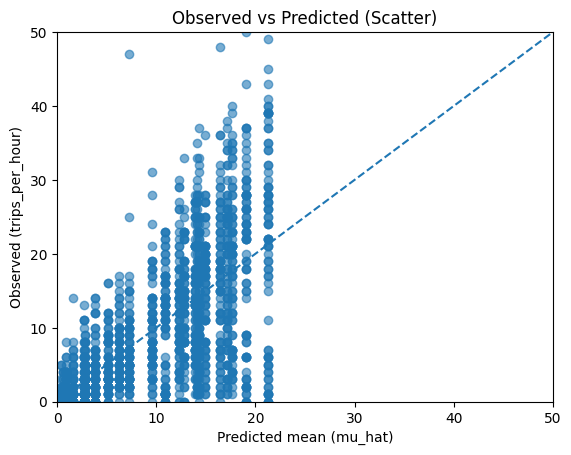

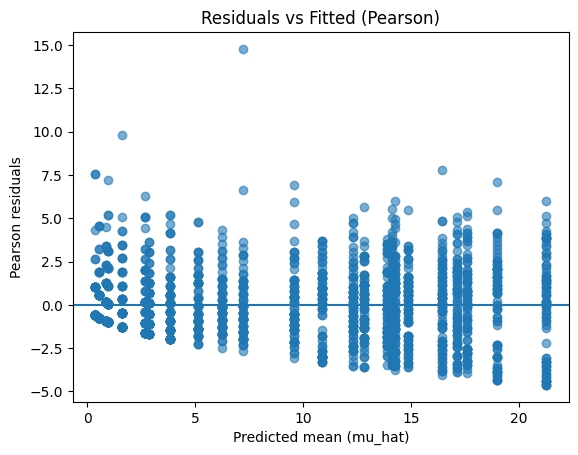

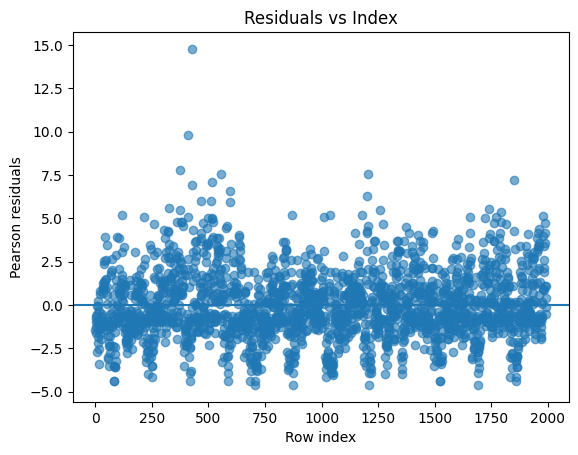

In [34]:
model0_spec = {
    "name": "Model 0 — Baseline (All days incl. weekend) — Hour FE",
    "weekday_only": False,
    "weekend_only": False,
    "no_rain_only": False,

    "hour_fe": True,
    "dow_fe": False,
    "cov_type": "HC0",

    "hour_seg": None,
    "rain_seg": None,
    "bins": [],

    "terms": [
        "C(hour_cat)"
    ],

    "plots": True,
    "axis_max": GLOBAL_AXIS_MAX,

    "posthoc": None
}

out_model0 = run_poisson_model(base_df, model0_spec)


### Model 1 - Only work-days and withought rain days - Baselins


MODEL: Model 1 — Routine (Weekdays only + No Rain) — Hour FE
Formula: trips_per_hour ~ C(hour_cat)
N rows: 1316
Dispersion (Pearson Chi2 / df_resid): 2.1495

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1316
Model:                            GLM   Df Residuals:                     1292
Model Family:                 Poisson   Df Model:                           23
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3655.3
Date:                Tue, 13 Jan 2026   Deviance:                       2786.6
Time:                        02:33:10   Pearson chi2:                 2.78e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.9998
Covariance Type:                  HC0                                         
                        coef    std err          z 

coef   std_err          z       p_value    ci_low  \
term                                                                       
Intercept          1.087249  0.133760   8.128370  4.351014e-16  0.825084   
C(hour_cat)[T.1]  -0.554444  0.207576  -2.671044  7.561576e-03 -0.961285   
C(hour_cat)[T.2]  -1.273351  0.246996  -5.155342  2.531684e-07 -1.757455   
C(hour_cat)[T.3]  -2.226683  0.302724  -7.355494  1.902216e-13 -2.820010   
C(hour_cat)[T.4]  -2.349490  0.288909  -8.132296  4.212356e-16 -2.915741   
C(hour_cat)[T.5]  -2.678337  0.326820  -8.195151  2.502791e-16 -3.318892   
C(hour_cat)[T.6]  -1.068899  0.211335  -5.057848  4.240137e-07 -1.483108   
C(hour_cat)[T.7]   0.251644  0.155900   1.614135  1.064982e-01 -0.053915   
C(hour_cat)[T.8]   1.610688  0.139866  11.515969  1.096206e-30  1.336556   
C(hour_cat)[T.9]   2.272998  0.140772  16.146692  1.198179e-58  1.997091   
C(hour_cat)[T.10]  2.165338  0.139616  15.509221  3.005014e-54  1.891696   
C(hour_cat)[T.11]  1.825684  0.142040  12.853289  8.242932e-38  1.547291   
C(hour_cat)[T.12]  1.805071  0.142055  12.706828  5.418805e-37  1.526648   
C(hour_cat)[T.13]  1.761384  0.142025  12.401963  2.549986e-35  1.483021   
C(hour_cat)[T.14]  1.638501  0.142749  11.478222  1.697349e-30  1.358719   
C(hour_cat)[T.15]  1.844672  0.139195  13.252472  4.365820e-40  1.571856   
C(hour_cat)[T.16]  1.960669  0.141650  13.841661  1.428658e-43  1.683041   
C(hour_cat)[T.17]  2.002169  0.141225  14.177114  1.269622e-45  1.725372   
C(hour_cat)[T.18]  2.055602  0.141586  14.518428  9.261012e-48  1.778099   
C(hour_cat)[T.19]  1.604292  0.145906  10.995379  4.022184e-28  1.318321   
C(hour_cat)[T.20]  1.218902  0.146069   8.344693  7.139912e-17  0.932611   
C(hour_cat)[T.21]  0.835435  0.155129   5.385426  7.227338e-08  0.531388   
C(hour_cat)[T.22]  0.664320  0.156457   4.246029  2.175924e-05  0.357670   
C(hour_cat)[T.23]  0.474648  0.170544   2.783142  5.383522e-03  0.140388   

                    ci_high  
term                         
Intercept          1.349413  
C(hour_cat)[T.1]  -0.147603  
C(hour_cat)[T.2]  -0.789247  
C(hour_cat)[T.3]  -1.633355  
C(hour_cat)[T.4]  -1.783240  
C(hour_cat)[T.5]  -2.037782  
C(hour_cat)[T.6]  -0.654691  
C(hour_cat)[T.7]   0.557202  
C(hour_cat)[T.8]   1.884819  
C(hour_cat)[T.9]   2.548906  
C(hour_cat)[T.10]  2.438981  
C(hour_cat)[T.11]  2.104078  
C(hour_cat)[T.12]  2.083494  
C(hour_cat)[T.13]  2.039747  
C(hour_cat)[T.14]  1.918284  
C(hour_cat)[T.15]  2.117489  
C(hour_cat)[T.16]  2.238298  
C(hour_cat)[T.17]  2.278966  
C(hour_cat)[T.18]  2.333105  
C(hour_cat)[T.19]  1.890262  
C(hour_cat)[T.20]  1.505192  
C(hour_cat)[T.21]  1.139482  
C(hour_cat)[T.22]  0.970970  
C(hour_cat)[T.23]  0.808909

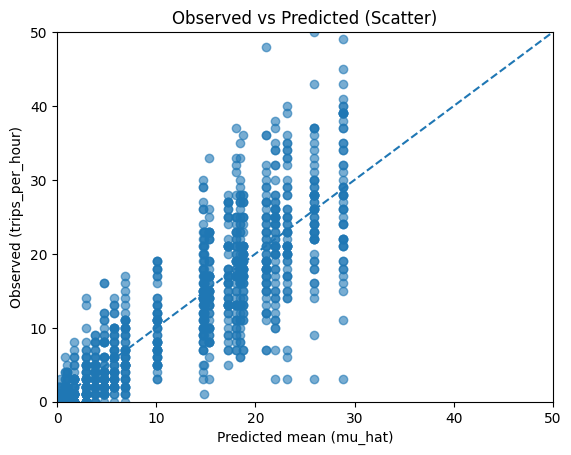

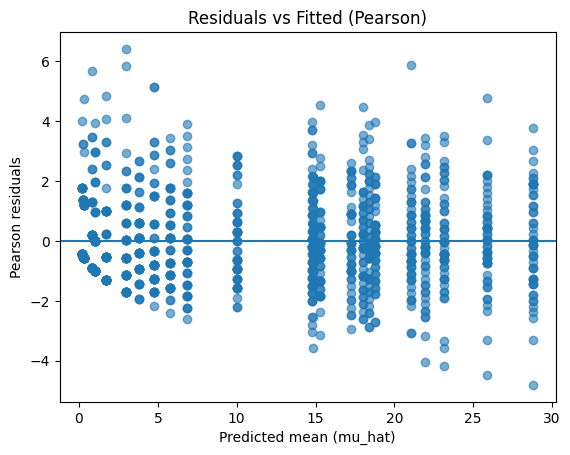

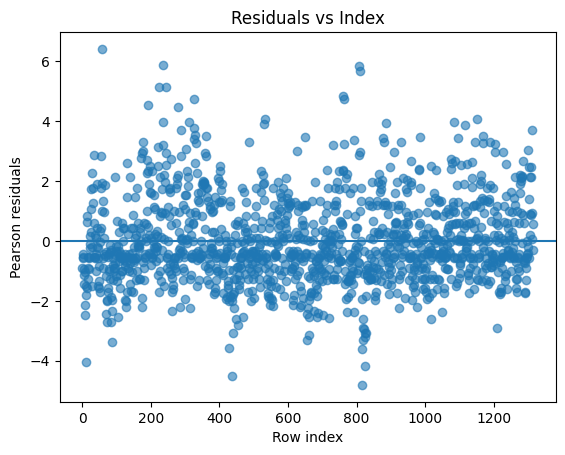

In [35]:
model1_spec = {
    "name": "Model 1 — Routine (Weekdays only + No Rain) — Hour FE",
    "weekday_only": True,
    "weekend_only": False,
    "no_rain_only": True,

    "hour_fe": True,
    "dow_fe": False,
    "cov_type": "HC0",

    "hour_seg": None,
    "rain_seg": None,
    "bins": [],

    "terms": ["C(hour_cat)"],

    "plots": True,
    "axis_max": GLOBAL_AXIS_MAX,  # ✅ fixed axis (same as Model 0)

    "posthoc": None
}

out_model1 = run_poisson_model(base_df, model1_spec)


### Model 2 - Only work-days without rain continous hourly without rain variable


MODEL: Model 2 — Routine Baseline (Weekdays, No-Rain): Hour-of-Day Effects & Post-hoc Segmentation
Formula: trips_per_hour ~ C(hour_cat) + temp_c + wind_speed_ms
N rows: 1316
Dispersion (Pearson Chi2 / df_resid): 2.0962

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1316
Model:                            GLM   Df Residuals:                     1290
Model Family:                 Poisson   Df Model:                           25
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3619.3
Date:                Tue, 13 Jan 2026   Deviance:                       2714.6
Time:                        02:33:10   Pearson chi2:                 2.70e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.9998
Covariance Type:                  HC0                              

coef   std_err          z       p_value    ci_low  \
term                                                                       
Intercept          0.819426  0.144498   5.670857  1.420851e-08  0.536216   
C(hour_cat)[T.1]  -0.543688  0.205561  -2.644894  8.171642e-03 -0.946581   
C(hour_cat)[T.2]  -1.260914  0.244881  -5.149088  2.617567e-07 -1.740873   
C(hour_cat)[T.3]  -2.206854  0.299470  -7.369192  1.716653e-13 -2.793805   
C(hour_cat)[T.4]  -2.320030  0.286489  -8.098143  5.580454e-16 -2.881539   
C(hour_cat)[T.5]  -2.642023  0.323628  -8.163754  3.247698e-16 -3.276323   
C(hour_cat)[T.6]  -1.030386  0.208985  -4.930428  8.204948e-07 -1.439990   
C(hour_cat)[T.7]   0.287983  0.154157   1.868115  6.174599e-02 -0.014159   
C(hour_cat)[T.8]   1.623726  0.136990  11.852904  2.078601e-32  1.355231   
C(hour_cat)[T.9]   2.255975  0.137810  16.370181  3.122862e-60  1.985873   
C(hour_cat)[T.10]  2.131632  0.137323  15.522794  2.432255e-54  1.862485   
C(hour_cat)[T.11]  1.779950  0.139564  12.753692  2.973233e-37  1.506411   
C(hour_cat)[T.12]  1.754375  0.140056  12.526219  5.366057e-36  1.479869   
C(hour_cat)[T.13]  1.707195  0.140364  12.162660  4.913221e-34  1.432087   
C(hour_cat)[T.14]  1.586877  0.141237  11.235521  2.728779e-29  1.310057   
C(hour_cat)[T.15]  1.792265  0.138149  12.973416  1.731390e-38  1.521498   
C(hour_cat)[T.16]  1.906199  0.141373  13.483500  1.956021e-41  1.629113   
C(hour_cat)[T.17]  1.959740  0.139525  14.045835  8.169965e-45  1.686277   
C(hour_cat)[T.18]  2.012487  0.139584  14.417716  4.003725e-47  1.738907   
C(hour_cat)[T.19]  1.566063  0.143642  10.902549  1.120731e-27  1.284530   
C(hour_cat)[T.20]  1.180477  0.144139   8.189870  2.615078e-16  0.897970   
C(hour_cat)[T.21]  0.802013  0.152965   5.243103  1.578984e-07  0.502207   
C(hour_cat)[T.22]  0.642271  0.153801   4.175991  2.966921e-05  0.340827   
C(hour_cat)[T.23]  0.463720  0.168923   2.745149  6.048335e-03  0.132636   
temp_c             0.022242  0.004463   4.984148  6.223543e-07  0.013496   
wind_speed_ms     -0.015323  0.004625  -3.313054  9.228304e-04 -0.024387   

                    ci_high  
term                         
Intercept          1.102636  
C(hour_cat)[T.1]  -0.140795  
C(hour_cat)[T.2]  -0.780956  
C(hour_cat)[T.3]  -1.619903  
C(hour_cat)[T.4]  -1.758522  
C(hour_cat)[T.5]  -2.007723  
C(hour_cat)[T.6]  -0.620783  
C(hour_cat)[T.7]   0.590124  
C(hour_cat)[T.8]   1.892221  
C(hour_cat)[T.9]   2.526078  
C(hour_cat)[T.10]  2.400780  
C(hour_cat)[T.11]  2.053490  
C(hour_cat)[T.12]  2.028880  
C(hour_cat)[T.13]  1.982302  
C(hour_cat)[T.14]  1.863697  
C(hour_cat)[T.15]  2.063032  
C(hour_cat)[T.16]  2.183284  
C(hour_cat)[T.17]  2.233203  
C(hour_cat)[T.18]  2.286067  
C(hour_cat)[T.19]  1.847596  
C(hour_cat)[T.20]  1.462983  
C(hour_cat)[T.21]  1.101820  
C(hour_cat)[T.22]  0.943715  
C(hour_cat)[T.23]  0.794804  
temp_c             0.030989  
wind_speed_ms     -0.006258

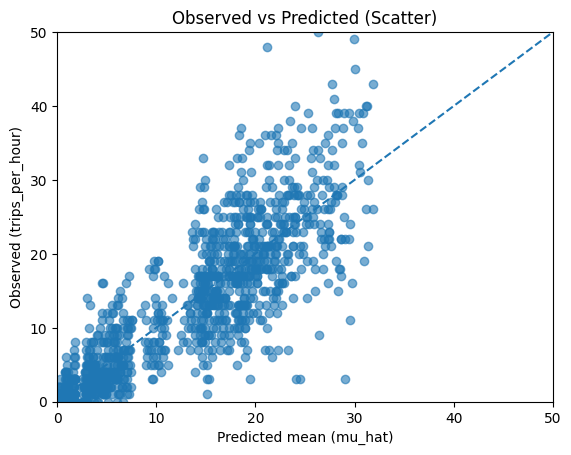

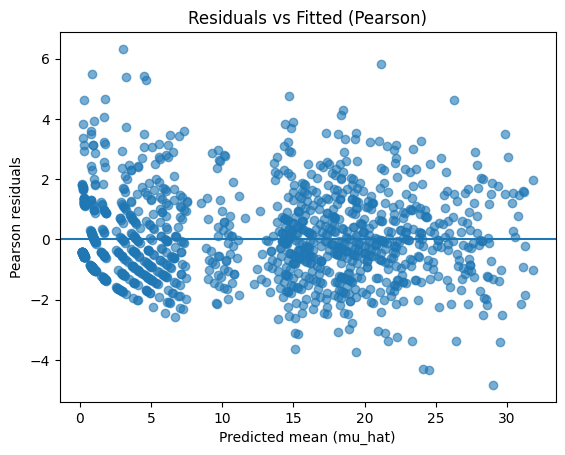

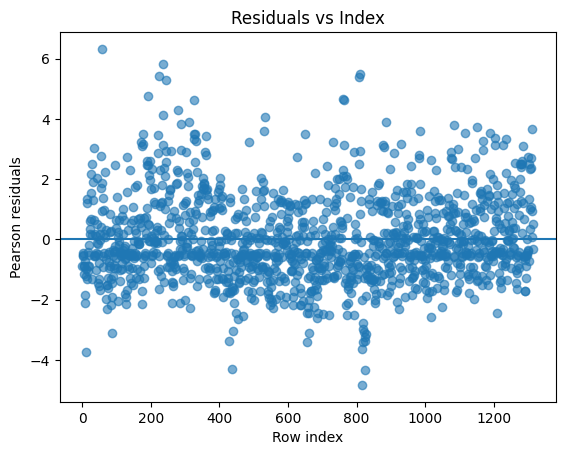

C:\Users\etaiw\AppData\Local\Temp\ipykernel_21796\1919046029.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_used[factor_col]):


level_i  level_j  effect_log        se          z          p_raw  \
141        7        9   -1.967993  0.092782 -21.210908  7.573633e-100   
142        7       10   -1.843649  0.092352 -19.963300   1.148697e-88   
125        6        9   -3.286362  0.168830 -19.465498   2.153896e-84   
126        6       10   -3.162018  0.168461 -18.770075   1.326983e-78   
150        7       18   -1.724504  0.095885 -17.985075   2.550421e-72   
..       ...      ...         ...       ...        ...            ...   
161        8       14    0.036849  0.067641   0.544769   5.859126e-01   
198       11       12    0.025576  0.065370   0.391249   6.956135e-01   
66         3        4    0.113177  0.370928   0.305118   7.602765e-01   
235       14       19    0.020814  0.076039   0.273725   7.842959e-01   
201       11       15   -0.012315  0.059736  -0.206150   8.366739e-01   

          IRR  IRR_ci_low  IRR_ci_high         p_adj  reject_0.05  
141  0.139737    0.116502     0.167606  2.090323e-97         True  
142  0.158239    0.132039     0.189638  3.158917e-86         True  
125  0.037390    0.026856     0.052055  5.901675e-82         True  
126  0.042340    0.030434     0.058905  3.622664e-76         True  
150  0.178261    0.147720     0.215118  6.937146e-70         True  
..        ...         ...          ...           ...          ...  
161  1.037536    0.908711     1.184624  1.000000e+00        False  
198  1.025906    0.902534     1.166141  1.000000e+00        False  
66   1.119830    0.541267     2.316818  1.000000e+00        False  
235  1.021032    0.879657     1.185128  1.000000e+00        False  
201  0.987761    0.878624     1.110454  1.000000e+00        False  

[276 rows x 11 columns]

In [36]:
model2_spec = {
    "name": "Model 2 — Routine Baseline (Weekdays, No-Rain): Hour-of-Day Effects & Post-hoc Segmentation",

    # Filters (same routine definition)
    "weekday_only": True,     # Sun–Thu (weekend==0)
    "no_rain_only": True,     # rain_mm == 0

    # Build hour categorical (24 levels)
    "hour_fe": True,

    # IMPORTANT: no rain_mm in the model terms
    "terms": [
        "C(hour_cat)",
        "temp_c",
        "wind_speed_ms",
        # אפשר להוסיף עוד משתנים אם יש לך, כל עוד הם לא גשם
    ],

    "cov_type": "HC0",
    "plots": True,
    "plots_mode": "key",
    "axis_max": GLOBAL_AXIS_MAX,

    # Post hoc on 24-hour factor (for segmentation)
    "posthoc": {
        "factor_col": "hour_cat",
        "correction": "holm"
    }
}

out_model2 = run_poisson_model(base_df, model2_spec, y_col="trips_per_hour")


## Post Hoc and Segments Analysis

#### Step 1: Analyze Model 2 Post-hoc Results for Segmentation

In [37]:
# =================================================
# STEP 1: ANALYZE POST-HOC RESULTS FOR SEGMENTATION
# =================================================

print("ANALYZING MODEL 2 POST-HOC RESULTS FOR SEGMENTATION")
print("=" * 60)

# Get the post-hoc results from Model 2
posthoc_results = out_model2["posthoc"]

# Sort by most significant differences (lowest p_adj)
most_significant = posthoc_results.sort_values('p_adj').head(15)
print("Most significant hour differences:")
print(most_significant[['level_i', 'level_j', 'IRR', 'p_adj', 'reject_0.05']].to_string())

# Look for extreme IRR values (< 0.5 or > 2.0) that indicate clear boundaries
extreme_differences = posthoc_results[
    (posthoc_results['IRR'] < 0.5) | (posthoc_results['IRR'] > 2.0)
].sort_values('p_adj')

print(f"\nExtreme differences (IRR < 0.5 or > 2.0): {len(extreme_differences)} found")
if len(extreme_differences) > 0:
    print(extreme_differences[['level_i', 'level_j', 'IRR', 'p_adj']].head(10).to_string())

# Check for similar hours (IRR close to 1.0, not significant)
similar_hours = posthoc_results[
    (~posthoc_results['reject_0.05']) & 
    (posthoc_results['IRR'].between(0.8, 1.25))
]

print(f"\nSimilar hour pairs (IRR 0.8-1.25, not significant): {len(similar_hours)} found")
if len(similar_hours) > 0:
    print(similar_hours[['level_i', 'level_j', 'IRR']].head(10).to_string())

ANALYZING MODEL 2 POST-HOC RESULTS FOR SEGMENTATION
Most significant hour differences:
     level_i  level_j       IRR         p_adj  reject_0.05
141        7        9  0.139737  2.090323e-97         True
142        7       10  0.158239  3.158917e-86         True
125        6        9  0.037390  5.901675e-82         True
126        6       10  0.042340  3.622664e-76         True
150        7       18  0.178261  6.937146e-70         True
134        6       18  0.047698  5.834247e-69         True
183        9       22  5.021377  7.817712e-68         True
90         4        9  0.010296  1.253134e-67         True
133        6       17  0.050281  1.756933e-66         True
149        7       17  0.187917  3.509153e-65         True
91         4       10  0.011659  4.236886e-64         True
132        6       16  0.053047  5.405707e-63         True
30         1        9  0.060831  1.288773e-62         True
99         4       18  0.013134  4.067299e-60         True
131        6       15  0.059

#### Step 2: Identify Key Segmentation Boundaries

In [38]:
# =================================================
# STEP 2: IDENTIFY KEY SEGMENTATION BOUNDARIES
# =================================================

print("IDENTIFYING KEY SEGMENTATION BOUNDARIES")
print("=" * 60)

# Key insights from your post-hoc analysis:
boundary_candidates = [
    {"boundary": "After hour 5", "evidence": "Hour 6 vs 9: IRR=0.037, Hour 6 vs 10: IRR=0.042"},
    {"boundary": "After hour 7", "evidence": "Hour 7 vs 9: IRR=0.14, Hour 7 vs 10: IRR=0.16"}, 
    {"boundary": "After hour 8", "evidence": "Morning transition to peak hours"},
    {"boundary": "After hour 11", "evidence": "Peak morning to midday transition"},
    {"boundary": "After hour 14", "evidence": "Midday to afternoon transition"},
    {"boundary": "After hour 17", "evidence": "Afternoon to evening transition"}
]

for boundary in boundary_candidates:
    print(f"• {boundary['boundary']}: {boundary['evidence']}")

# Proposed 6-segment boundaries based on analysis
proposed_segments = {
    "boundaries": [0, 6, 9, 12, 15, 18, 24],
    "labels": ["early_morning", "morning", "peak_morning", "midday", "late_afternoon", "evening"],
    "rationale": "Separates very different hours (6 vs 9-11) while grouping similar ones"
}

print(f"\nProposed 6-segment boundaries: {proposed_segments['boundaries']}")
print(f"Labels: {proposed_segments['labels']}")
print(f"Rationale: {proposed_segments['rationale']}")

# Test with different segment counts
segment_options = {
    5: {"boundaries": [0, 7, 11, 15, 19, 24], "labels": ["early_morning", "morning", "midday", "afternoon", "evening"]},
    6: {"boundaries": [0, 6, 9, 12, 15, 18, 24], "labels": ["early_morning", "morning", "peak_morning", "midday", "late_afternoon", "evening"]},
    7: {"boundaries": [0, 6, 9, 12, 15, 17, 20, 24], "labels": ["early_morning", "morning", "peak_morning", "midday", "afternoon", "evening", "late_evening"]}
}

print(f"\nAlternative options:")
for n_seg, config in segment_options.items():
    print(f"  {n_seg} segments: {config['boundaries']} - {config['labels']}")

IDENTIFYING KEY SEGMENTATION BOUNDARIES
• After hour 5: Hour 6 vs 9: IRR=0.037, Hour 6 vs 10: IRR=0.042
• After hour 7: Hour 7 vs 9: IRR=0.14, Hour 7 vs 10: IRR=0.16
• After hour 8: Morning transition to peak hours
• After hour 11: Peak morning to midday transition
• After hour 14: Midday to afternoon transition
• After hour 17: Afternoon to evening transition

Proposed 6-segment boundaries: [0, 6, 9, 12, 15, 18, 24]
Labels: ['early_morning', 'morning', 'peak_morning', 'midday', 'late_afternoon', 'evening']
Rationale: Separates very different hours (6 vs 9-11) while grouping similar ones

Alternative options:
  5 segments: [0, 7, 11, 15, 19, 24] - ['early_morning', 'morning', 'midday', 'afternoon', 'evening']
  6 segments: [0, 6, 9, 12, 15, 18, 24] - ['early_morning', 'morning', 'peak_morning', 'midday', 'late_afternoon', 'evening']
  7 segments: [0, 6, 9, 12, 15, 17, 20, 24] - ['early_morning', 'morning', 'peak_morning', 'midday', 'afternoon', 'evening', 'late_evening']


### Create 4-Segment Daytime Segmentation

#### Step 1: Analyze Your Post-hoc Patterns

In [39]:
# Look at the post-hoc results to identify natural groupings
posthoc_results = out_model2["posthoc"]

# Sort by adjusted p-value to see most significant differences
significant_diffs = posthoc_results[posthoc_results['reject_0.05']].sort_values('p_adj')
print("Most significant hour differences:")
print(significant_diffs[['level_i', 'level_j', 'IRR', 'p_adj']].head(20))

# Look at hours that are NOT significantly different (similar hours)
non_significant = posthoc_results[~posthoc_results['reject_0.05']]
print("\nHours with similar trip patterns:")
print(non_significant[['level_i', 'level_j', 'IRR']].head(20))

Most significant hour differences:
     level_i  level_j       IRR         p_adj
141        7        9  0.139737  2.090323e-97
142        7       10  0.158239  3.158917e-86
125        6        9  0.037390  5.901675e-82
126        6       10  0.042340  3.622664e-76
150        7       18  0.178261  6.937146e-70
134        6       18  0.047698  5.834247e-69
183        9       22  5.021377  7.817712e-68
90         4        9  0.010296  1.253134e-67
133        6       17  0.050281  1.756933e-66
149        7       17  0.187917  3.509153e-65
91         4       10  0.011659  4.236886e-64
132        6       16  0.053047  5.405707e-63
30         1        9  0.060831  1.288773e-62
99         4       18  0.013134  4.067299e-60
131        6       15  0.059448  4.692469e-60
51         2        9  0.029692  1.165489e-59
196       10       22  4.434261  2.233482e-59
127        6       11  0.060185  8.248787e-59
98         4       17  0.013846  1.249929e-58
8          0        9  0.104771  8.025755e-58

#### Step 2: Define Your 4 Segments Based on Patterns


MODEL: Model 3 — 4-Segment Daytime Analysis (Weekdays, No-Rain)
Formula: trips_per_hour ~ C(daytime_segment) + temp_c + wind_speed_ms
N rows: 1316
Dispersion (Pearson Chi2 / df_resid): 3.9184

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1316
Model:                            GLM   Df Residuals:                     1310
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4767.1
Date:                Tue, 13 Jan 2026   Deviance:                       5010.2
Time:                        02:33:10   Pearson chi2:                 5.13e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9988
Covariance Type:                  HC0                                         
                

coef   std_err          z  \
term                                                                
Intercept                          -0.411944  0.110250  -3.736441   
C(daytime_segment)[T.morning_noon]  2.706994  0.078427  34.516118   
C(daytime_segment)[T.afternoon]     2.277017  0.079084  28.792241   
C(daytime_segment)[T.evening]       2.082029  0.080288  25.932125   
temp_c                              0.056397  0.005898   9.562884   
wind_speed_ms                       0.004487  0.006048   0.741915   

                                          p_value    ci_low   ci_high  
term                                                                   
Intercept                            1.866436e-04 -0.628030 -0.195857  
C(daytime_segment)[T.morning_noon]  4.597280e-261  2.553280  2.860708  
C(daytime_segment)[T.afternoon]     2.682704e-182  2.122014  2.432020  
C(daytime_segment)[T.evening]       2.893003e-148  1.924668  2.239389  
temp_c                               1.145200e-21  0.044838  0.067956  
wind_speed_ms                        4.581390e-01 -0.007366  0.016340

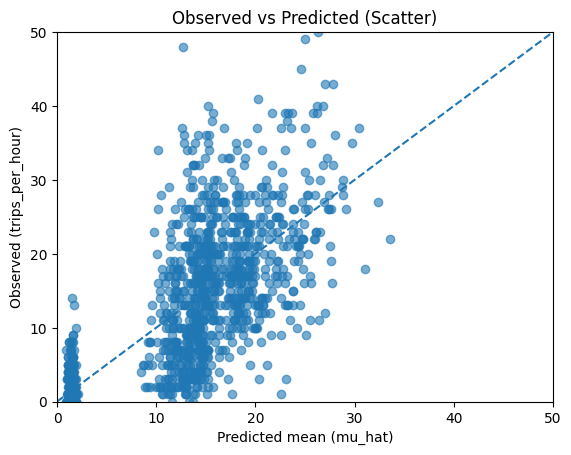

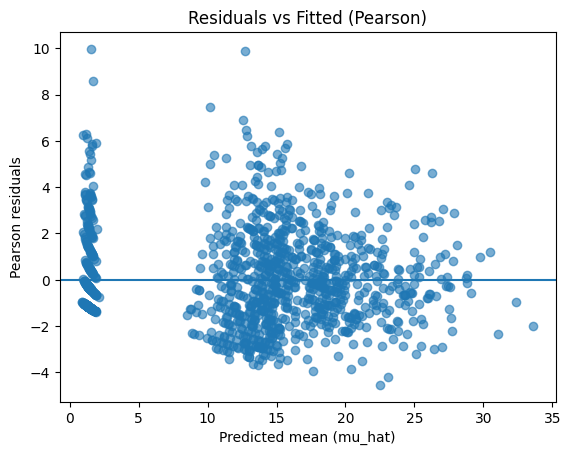

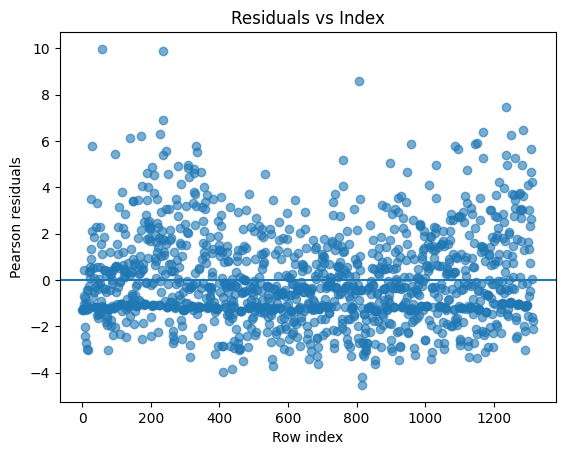

C:\Users\etaiw\AppData\Local\Temp\ipykernel_21796\1919046029.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_used[factor_col]):


level_i       level_j  effect_log        se          z  \
0  early_morning  morning_noon   -2.706994  0.078427 -34.516118   
1  early_morning     afternoon   -2.277017  0.079084 -28.792241   
2  early_morning       evening   -2.082029  0.080288 -25.932125   
4   morning_noon       evening    0.624966  0.044201  14.139315   
3   morning_noon     afternoon    0.429977  0.040356  10.654694   
5      afternoon       evening    0.194988  0.038474   5.068095   

           p_raw       IRR  IRR_ci_low  IRR_ci_high          p_adj  \
0  4.597280e-261  0.066737    0.057228     0.077826  2.758368e-260   
1  2.682704e-182  0.102590    0.087859     0.119790  1.341352e-181   
2  2.893003e-148  0.124677    0.106523     0.145925  1.157201e-147   
4   2.173909e-45  1.868182    1.713148     2.037246   6.521728e-45   
3   1.657888e-26  1.537223    1.420317     1.663751   3.315776e-26   
5   4.018169e-07  1.215297    1.127023     1.310485   4.018169e-07   

   reject_0.05  
0         True  
1         True  
2         True  
4         True  
3         True  
5         True

In [40]:
# Create a new model spec for 4-segment analysis
model_4segment_spec = {
    "name": "Model 3 — 4-Segment Daytime Analysis (Weekdays, No-Rain)",
    
    # Same filters as Model 2
    "weekday_only": True,
    "no_rain_only": True,
    
    # Add custom hour segmentation instead of hour_fe
    "hour_seg": {
        "hour_col": "hour",
        "out_col": "daytime_segment", 
        "edges": [0, 7, 10, 15, 24],  # Adjust these based on your post-hoc analysis
        #"edges": [0, 6, 12, 17, 24],  # Adjust these based on your post-hoc analysis
        "labels": ["early_morning", "morning_noon", "afternoon", "evening"]
    },
    
    # Weather variables (same as Model 2)
    "terms": [
        "C(daytime_segment)",
        "temp_c", 
        "wind_speed_ms"
    ],
    
    "cov_type": "HC0",
    "plots": True,
    "axis_max": GLOBAL_AXIS_MAX,
    
    # Post-hoc on the 4 segments
    "posthoc": {
        "factor_col": "daytime_segment",
        "correction": "holm"
    }
}

# Run the model
out_model_4seg = run_poisson_model(base_df, model_4segment_spec)

#### Step 3: Refine Segment Boundaries

In [41]:
# After running the initial model, check which segments are too heterogeneous
segment_results = out_model_4seg["posthoc"]
print("Check if segments are internally consistent:")
print(segment_results)

# If segments show internal differences, adjust boundaries:
# Example: if morning (6-12) shows hour 6 very different from hours 9-11,
# split into: early_morning (0-7), morning_peak (8-12), etc.

Check if segments are internally consistent:
         level_i       level_j  effect_log        se          z  \
0  early_morning  morning_noon   -2.706994  0.078427 -34.516118   
1  early_morning     afternoon   -2.277017  0.079084 -28.792241   
2  early_morning       evening   -2.082029  0.080288 -25.932125   
4   morning_noon       evening    0.624966  0.044201  14.139315   
3   morning_noon     afternoon    0.429977  0.040356  10.654694   
5      afternoon       evening    0.194988  0.038474   5.068095   

           p_raw       IRR  IRR_ci_low  IRR_ci_high          p_adj  \
0  4.597280e-261  0.066737    0.057228     0.077826  2.758368e-260   
1  2.682704e-182  0.102590    0.087859     0.119790  1.341352e-181   
2  2.893003e-148  0.124677    0.106523     0.145925  1.157201e-147   
4   2.173909e-45  1.868182    1.713148     2.037246   6.521728e-45   
3   1.657888e-26  1.537223    1.420317     1.663751   3.315776e-26   
5   4.018169e-07  1.215297    1.127023     1.310485   4.018169e-0

#### Step 4: Validate Your Segmentation

In [42]:
# Compare dispersion and fit statistics
print(f"24-hour Model dispersion: {out_model2['dispersion']:.3f}")
print(f"4-segment Model dispersion: {out_model_4seg['dispersion']:.3f}")

# The 4-segment model should have:
# - Lower dispersion (better fit)
# - More interpretable coefficients
# - Clear post-hoc differences between segments

24-hour Model dispersion: 2.096
4-segment Model dispersion: 3.918


#### Step 5: Final Optimized Segmentation

In [43]:
# Recommended final segmentation
optimized_segments = {
    "hour_seg": {
        "hour_col": "hour",
        "out_col": "daytime_segment",
        "edges": [0, 7, 10, 15, 24],  # Adjust based on your post-hoc
        # "edges": [0, 7, 11, 16, 24],  # Adjust based on your post-hoc
        "labels": ["early_morning", "morning", "noon_afternoon", "evening"]
    }
}

# This creates:
# - Early Morning (0-6): Pre-commute hours
# - Morning (7-10): Peak commute hours  
# - Noon-Afternoon (11-15): Midday steady usage
# - Evening (16-23): Evening decline

### Create 6-Segment Daytime Segmentation

#### Step 2: Define Your 6 Segments Based on Patterns

In [44]:
# Create the 6-segment model specification
model_6segment_spec = {
    "name": "Model 4 — 6-Segment Daytime Analysis (Weekdays, No-Rain)",
    
    # Same data filters as your successful models
    "weekday_only": True,     # Sun–Thu (weekend==0)
    "no_rain_only": True,     # rain_mm == 0
    
    # 6-segment daytime categorization
    "hour_seg": {
        "hour_col": "hour",
        "out_col": "daytime_segment", 
        "edges": [0, 6, 9, 12, 15, 18, 24],
        "labels": ["early_morning", "morning", "peak_morning", "midday", "late_afternoon", "evening"]
    },
    
    "terms": [
        "C(daytime_segment)",
        "temp_c",
        "wind_speed_ms"
    ],
    
    "cov_type": "HC0",
    "plots": True,
    "axis_max": GLOBAL_AXIS_MAX,
    
    "posthoc": {
        "factor_col": "daytime_segment",
        "correction": "holm"
    }
}


MODEL: Model 4 — 6-Segment Daytime Analysis (Weekdays, No-Rain)
Formula: trips_per_hour ~ C(daytime_segment) + temp_c + wind_speed_ms
N rows: 1316
Dispersion (Pearson Chi2 / df_resid): 3.6582

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1316
Model:                            GLM   Df Residuals:                     1308
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4563.4
Date:                Tue, 13 Jan 2026   Deviance:                       4602.8
Time:                        02:33:11   Pearson chi2:                 4.78e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9991
Covariance Type:                  HC0                                         
                

coef   std_err          z  \
term                                                                  
Intercept                            -0.407731  0.117912  -3.457908   
C(daytime_segment)[T.morning]         2.666499  0.104410  25.538762   
C(daytime_segment)[T.peak_morning]    2.828973  0.095868  29.508967   
C(daytime_segment)[T.midday]          2.610366  0.096877  26.945182   
C(daytime_segment)[T.late_afternoon]  2.878990  0.096499  29.834434   
C(daytime_segment)[T.evening]         1.965909  0.098302  19.998673   
temp_c                                0.040365  0.005847   6.903939   
wind_speed_ms                        -0.016364  0.006370  -2.568901   

                                            p_value    ci_low   ci_high  
term                                                                     
Intercept                              5.443869e-04 -0.638835 -0.176626  
C(daytime_segment)[T.morning]         7.319547e-144  2.461859  2.871138  
C(daytime_segment)[T.peak_morning]    2.209066e-191  2.641075  3.016872  
C(daytime_segment)[T.midday]          6.496228e-160  2.420491  2.800241  
C(daytime_segment)[T.late_afternoon]  1.397633e-195  2.689856  3.068125  
C(daytime_segment)[T.evening]          5.655721e-89  1.773241  2.158577  
temp_c                                 5.058018e-12  0.028906  0.051824  
wind_speed_ms                          1.020215e-02 -0.028849 -0.003879

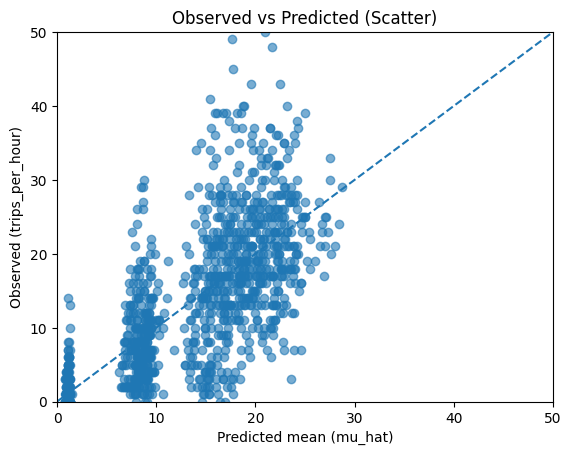

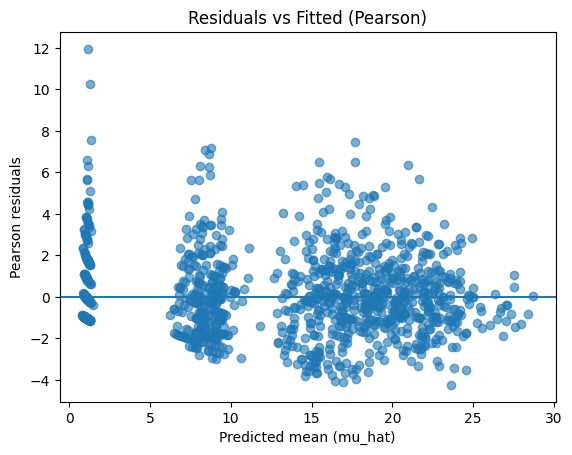

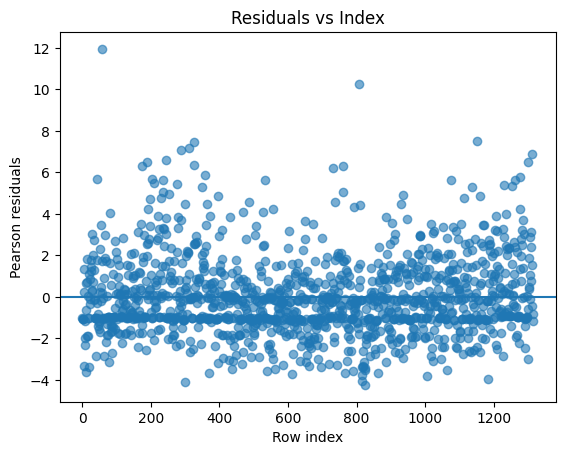

C:\Users\etaiw\AppData\Local\Temp\ipykernel_21796\1919046029.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_used[factor_col]):


level_i         level_j  effect_log        se          z  \
3    early_morning  late_afternoon   -2.878990  0.096499 -29.834434   
1    early_morning    peak_morning   -2.828973  0.095868 -29.508967   
2    early_morning          midday   -2.610366  0.096877 -26.945182   
0    early_morning         morning   -2.666499  0.104410 -25.538762   
4    early_morning         evening   -1.965909  0.098302 -19.998673   
14  late_afternoon         evening    0.913081  0.050844  17.958454   
11    peak_morning         evening    0.863064  0.050921  16.949021   
13          midday         evening    0.644457  0.051188  12.589959   
8          morning         evening    0.700590  0.071946   9.737759   
12          midday  late_afternoon   -0.268624  0.037667  -7.131617   
9     peak_morning          midday    0.218607  0.040057   5.457467   
7          morning  late_afternoon   -0.212492  0.069746  -3.046645   
5          morning    peak_morning   -0.162475  0.068766  -2.362730   
10    peak_morning  late_afternoon   -0.050017  0.039837  -1.255540   
6          morning          midday    0.056133  0.070345   0.797966   

            p_raw       IRR  IRR_ci_low  IRR_ci_high          p_adj  \
3   1.397633e-195  0.056191    0.046508     0.067891  2.096450e-194   
1   2.209066e-191  0.059073    0.048954     0.071285  3.092693e-190   
2   6.496228e-160  0.073508    0.060795     0.088878  8.445096e-159   
0   7.319547e-144  0.069495    0.056634     0.085277  8.783457e-143   
4    5.655721e-89  0.140029    0.115489     0.169782   6.221293e-88   
14   4.121247e-72  2.491990    2.255625     2.753123   4.121247e-71   
11   1.956866e-64  2.370414    2.145256     2.619203   1.761180e-63   
13   2.397981e-36  1.904952    1.723106     2.105990   1.918385e-35   
8    2.080923e-22  2.014941    1.749931     2.320084   1.456646e-21   
12   9.919670e-13  0.764430    0.710028     0.823001   5.951802e-12   
9    4.829757e-08  1.244343    1.150385     1.345974   2.414879e-07   
7    2.314111e-03  0.808567    0.705256     0.927012   9.256445e-03   
5    1.814089e-02  0.850038    0.742854     0.972686   5.442266e-02   
10   2.092827e-01  0.951213    0.879768     1.028461   4.185655e-01   
6    4.248904e-01  1.057738    0.921509     1.214107   4.248904e-01   

    reject_0.05  
3          True  
1          True  
2          True  
0          True  
4          True  
14         True  
11         True  
13         True  
8          True  
12         True  
9          True  
7          True  
5         False  
10        False  
6         False

In [45]:
# Run the 6-segment model
out_model_6seg = run_poisson_model(base_df, model_6segment_spec)

### Optimal Segmentation (12 Segments - dispertion = 2.3038)


MODEL: Optimized 12-Segment Model - Target < 2.5 Dispersion
Formula: trips_per_hour ~ C(daytime_segment) + temp_c + wind_speed_ms
N rows: 1316
Dispersion (Pearson Chi2 / df_resid): 2.3038

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1316
Model:                            GLM   Df Residuals:                     1302
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3734.2
Date:                Tue, 13 Jan 2026   Deviance:                       2944.3
Time:                        02:33:11   Pearson chi2:                 3.00e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9997
Covariance Type:                  HC0                                         
                    

coef   std_err          z  \
term                                                                   
Intercept                              0.403736  0.116694   3.459781   
C(daytime_segment)[T.early_morning]   -1.382515  0.159602  -8.662266   
C(daytime_segment)[T.morning_rush]     0.737900  0.128310   5.750929   
C(daytime_segment)[T.peak_morning]     2.074170  0.107342  19.323073   
C(daytime_segment)[T.mid_morning]      2.709887  0.108546  24.965288   
C(daytime_segment)[T.late_morning]     2.429280  0.106646  22.778931   
C(daytime_segment)[T.early_afternoon]  2.148070  0.105648  20.332354   
C(daytime_segment)[T.mid_afternoon]    2.314459  0.107600  21.509885   
C(daytime_segment)[T.late_afternoon]   2.447215  0.106545  22.968793   
C(daytime_segment)[T.early_evening]    2.024713  0.116056  17.445963   
C(daytime_segment)[T.evening]          1.637459  0.116637  14.038888   
C(daytime_segment)[T.night]            1.101871  0.112477   9.796436   
temp_c                                 0.020182  0.004641   4.348836   
wind_speed_ms                         -0.017928  0.004991  -3.591851   

                                             p_value    ci_low   ci_high  
term                                                                      
Intercept                               5.406145e-04  0.175020  0.632452  
C(daytime_segment)[T.early_morning]     4.624793e-18 -1.695329 -1.069701  
C(daytime_segment)[T.morning_rush]      8.875427e-09  0.486417  0.989382  
C(daytime_segment)[T.peak_morning]      3.435777e-83  1.863785  2.284556  
C(daytime_segment)[T.mid_morning]      1.457134e-137  2.497140  2.922633  
C(daytime_segment)[T.late_morning]     7.417858e-115  2.220258  2.638302  
C(daytime_segment)[T.early_afternoon]   6.653320e-92  1.941004  2.355136  
C(daytime_segment)[T.mid_afternoon]    1.258172e-102  2.103568  2.525351  
C(daytime_segment)[T.late_afternoon]   9.563102e-117  2.238390  2.656039  
C(daytime_segment)[T.early_evening]     3.694359e-68  1.797247  2.252179  
C(daytime_segment)[T.evening]           9.011507e-45  1.408854  1.866064  
C(daytime_segment)[T.night]             1.166286e-22  0.881420  1.322321  
temp_c                                  1.368618e-05  0.011086  0.029278  
wind_speed_ms                           3.283370e-04 -0.027711 -0.008145

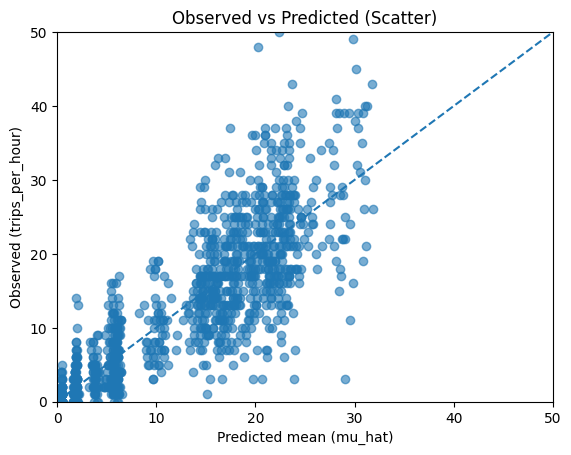

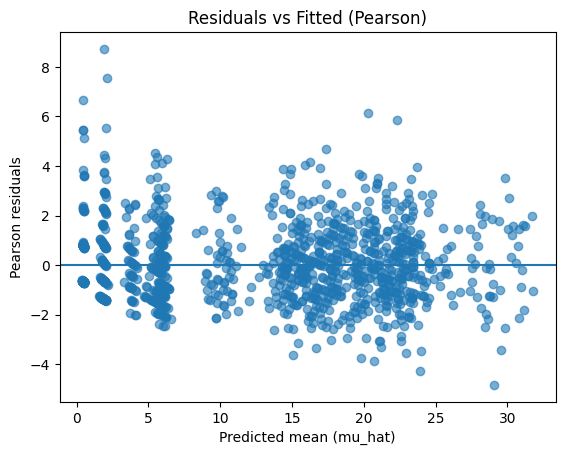

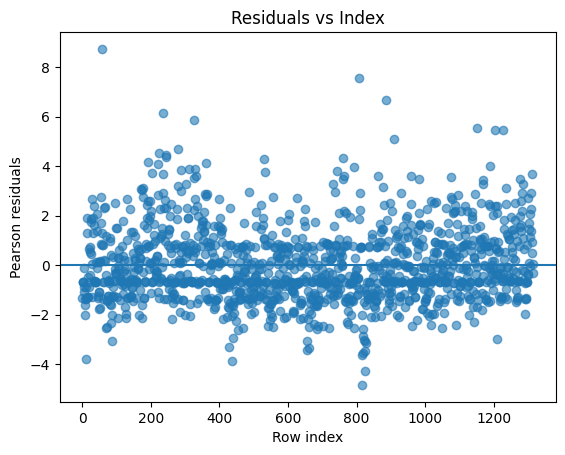

C:\Users\etaiw\AppData\Local\Temp\ipykernel_21796\1919046029.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_used[factor_col]):


level_i          level_j  effect_log        se          z  \
13    early_morning      mid_morning   -4.092401  0.132418 -30.905241   
17    early_morning   late_afternoon   -3.829730  0.130621 -29.319328   
14    early_morning     late_morning   -3.811795  0.130718 -29.160540   
16    early_morning    mid_afternoon   -3.696974  0.131409 -28.133308   
15    early_morning  early_afternoon   -3.530585  0.129694 -27.222430   
..              ...              ...         ...       ...        ...   
46     late_morning    mid_afternoon    0.114821  0.046947   2.445764   
53  early_afternoon    early_evening    0.123357  0.064465   1.913562   
32     peak_morning  early_afternoon   -0.073900  0.054205  -1.363324   
35     peak_morning    early_evening    0.049457  0.072353   0.683559   
47     late_morning   late_afternoon   -0.017935  0.046537  -0.385379   

            p_raw       IRR  IRR_ci_low  IRR_ci_high          p_adj  \
13  1.015678e-209  0.016699    0.012882     0.021648  6.703472e-208   
17  5.881865e-189  0.021715    0.016811     0.028052  3.823212e-187   
14  6.141651e-187  0.022108    0.017112     0.028565  3.930657e-185   
16  3.835493e-174  0.024798    0.019168     0.032084  2.416361e-172   
15  3.524919e-163  0.029288    0.022714     0.037765  2.185450e-161   
..            ...       ...         ...          ...            ...   
46   1.445454e-02  1.121672    1.023067     1.229781   7.227271e-02   
53   5.567610e-02  1.131288    0.997011     1.283650   2.227044e-01   
32   1.727804e-01  0.928765    0.835151     1.032872   5.183412e-01   
35   4.942536e-01  1.050701    0.911782     1.210785   9.885072e-01   
47   6.999566e-01  0.982225    0.896598     1.076031   9.885072e-01   

    reject_0.05  
13         True  
17         True  
14         True  
16         True  
15         True  
..          ...  
46        False  
53        False  
32        False  
35        False  
47        False  

[66 rows x 11 columns]

In [46]:
optimized_12segment_spec = {
    "name": "Optimized 12-Segment Model - Target < 2.5 Dispersion",
    
    # Same filters
    "weekday_only": True,
    "no_rain_only": True,
    
    # Optimized boundaries based on post-hoc analysis
    # Key insights: Hours 6-7 very different from 9-10, hour 9 very different from 22
    "hour_seg": {
        "hour_col": "hour",
        "out_col": "daytime_segment",
        "edges": [0, 2, 6, 7, 8, 9, 11, 14, 16, 18, 19, 20, 24],  # Optimized boundaries
        "labels": [
            "deep_night",      # [0, 3): hours 0-2
            "early_morning",   # [3, 7): hours 3-6
            "morning_rush",    # [7, 8): hour 7
            "peak_morning",    # [8, 9): hour 8
            "mid_morning",     # [9, 10): hour 9
            "late_morning",    # [10, 12): hours 10-11
            "early_afternoon", # [12, 15): hours 12-14
            "mid_afternoon",   # [15, 17): hours 15-16
            "late_afternoon",  # [17, 19): hours 17-18
            "early_evening",   # [19, 20): hour 19
            "evening",         # [20, 21): hour 20
            "night"            # [21, 24): hours 21-23 (wait, this should be [21, 24): hours 21-23)
        ]
    },
    
    "terms": ["C(daytime_segment)", "temp_c", "wind_speed_ms"],
    "cov_type": "HC0",  # Keep robust SE - should work with optimized boundaries
    "plots": True,
    "axis_max": GLOBAL_AXIS_MAX,
    
    "posthoc": {
        "factor_col": "daytime_segment",
        "correction": "holm"
    }
}

out_12seg_final = run_poisson_model(base_df, optimized_12segment_spec)

 רעיון של בעצם לחפש כמה סגמנטים אפשר לחלק ככה שהדיספרסיה תפגע כמה שפחות, עבור 4 סגמנטים קיבלנו בערך דיספרסיה של 4 ועבור 6 קיבלנו דיספרסיה של 3.6.
בוא ננסה רגע לבחור 12 סגמנטים, נראה מה נקבל, אנחנו רוצים דיספריסה כמה שיותר קרובה לדיספרסיה של ה24 שעות שלנו שזה בערך 2
אז אם 12 סגמנטים מצליחים לתפוס את רוב הקבוצות הדומות נקבל ערך קרוב ל2 ואם לא אז צריך יותר סגמנטים, אם הערך קרוב ל2 אפשר טיפה להוריד את כמות הסגמנטים וככה למצוא את הנקודה הכי טובה בשבילנו.

הדוגמא שעולה לי בראש היא שבלילה יש התנהגות מאוד דומה ואחידה של כלום נסיעות, ולכן הם יכולים להיכנס לסגמנט אחד וכנראה שלא יפגעו כמעט בתוצאות, אבל שעת שעות היום הפעילות שונות אחת מהשנייה וקשה יותר להכניס אותם לסגמנט אחד ולכן הם פוגעות בדיספרסיה.
אז למשל אם ניקח בערך 18 סגמנטים למשל, שזה תופס את כל שעות הלפנות בוקר שממש אין נסיעות, נצפה לדיספרסיה שקרובה ל2.
תחשבי על זה ואם זה באמת יהיה ככה, אולי זה משהו שאפשר יהיה להכניס בדוח ולדבר עליו ואיך עשית אופטימיזציה למצוא את כמות הסגמנטים האופטימלית.

# Rain Model

### Model 3a - rain (float) + hours (seg 12)


MODEL: Model 3a — Weekdays + 12-hour segmentation + rain_mm (continuous)
Formula: trips_per_hour ~ C(daytime_segment) + rain_mm
N rows: 1441
Dispersion (Pearson Chi2 / df_resid): 2.4706

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1441
Model:                            GLM   Df Residuals:                     1428
Model Family:                 Poisson   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4104.3
Date:                Tue, 13 Jan 2026   Deviance:                       3358.2
Time:                        03:03:59   Pearson chi2:                 3.53e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9997
Covariance Type:                  HC0                                         
                      

coef   std_err          z  \
term                                                                   
Intercept                              0.568317  0.100495   5.655189   
C(daytime_segment)[T.early_morning]   -1.408963  0.158513  -8.888606   
C(daytime_segment)[T.morning_rush]     0.724422  0.128333   5.644862   
C(daytime_segment)[T.peak_morning]     2.091461  0.109242  19.145128   
C(daytime_segment)[T.mid_morning]      2.778649  0.108398  25.633701   
C(daytime_segment)[T.late_morning]     2.509825  0.106114  23.652195   
C(daytime_segment)[T.early_afternoon]  2.240655  0.104066  21.531003   
C(daytime_segment)[T.mid_afternoon]    2.413094  0.105100  22.959886   
C(daytime_segment)[T.late_afternoon]   2.514780  0.105508  23.834867   
C(daytime_segment)[T.early_evening]    2.116888  0.115114  18.389527   
C(daytime_segment)[T.evening]          1.731837  0.115726  14.964983   
C(daytime_segment)[T.night]            1.166920  0.112175  10.402636   
rain_mm                               -0.205831  0.138929  -1.481553   

                                             p_value    ci_low   ci_high  
term                                                                      
Intercept                               1.556748e-08  0.371351  0.765283  
C(daytime_segment)[T.early_morning]     6.188051e-19 -1.719644 -1.098283  
C(daytime_segment)[T.morning_rush]      1.653138e-08  0.472894  0.975951  
C(daytime_segment)[T.peak_morning]      1.062773e-81  1.877350  2.305572  
C(daytime_segment)[T.mid_morning]      6.425674e-145  2.566192  2.991105  
C(daytime_segment)[T.late_morning]     1.120509e-123  2.301846  2.717804  
C(daytime_segment)[T.early_afternoon]  7.978795e-103  2.036688  2.444621  
C(daytime_segment)[T.mid_afternoon]    1.173824e-116  2.207101  2.619087  
C(daytime_segment)[T.late_afternoon]   1.453553e-125  2.307987  2.721573  
C(daytime_segment)[T.early_evening]     1.593648e-75  1.891269  2.342507  
C(daytime_segment)[T.evening]           1.243552e-50  1.505019  1.958656  
C(daytime_segment)[T.night]             2.411673e-25  0.947060  1.386779  
rain_mm                                 1.384593e-01 -0.478126  0.066465

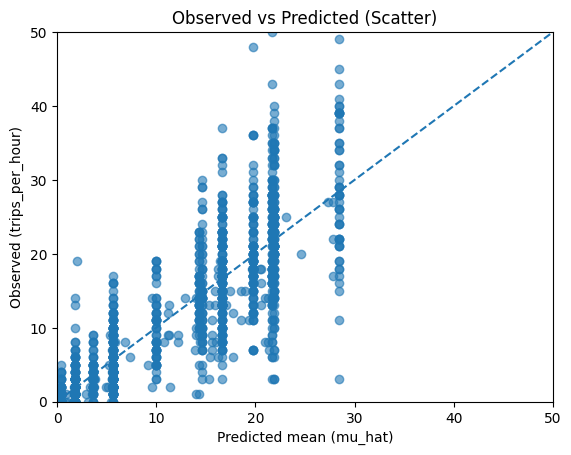

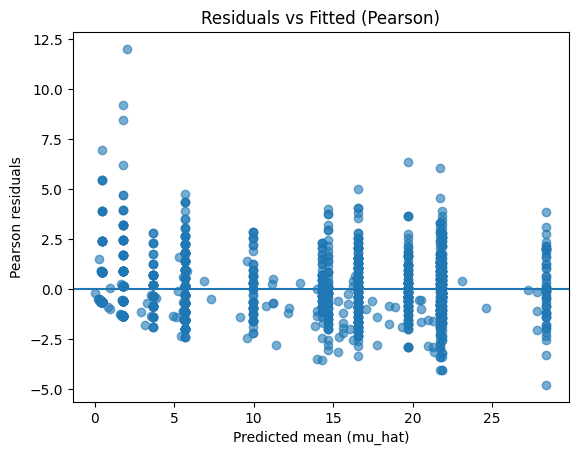

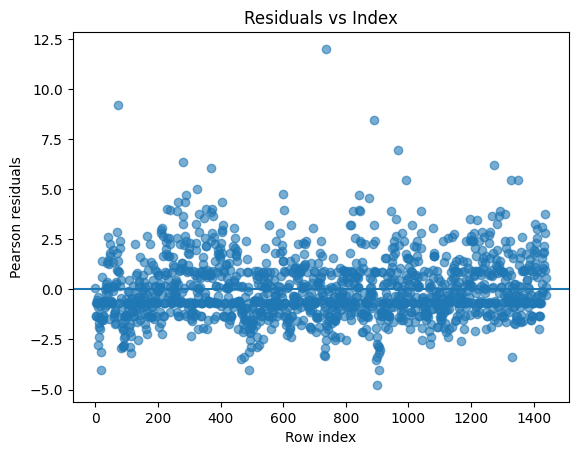

In [55]:
model3a_rain_cont_spec = {
    "name": "Model 3a — Weekdays + 12-hour segmentation + rain_mm (continuous)",
    "weekday_only": True,
    "no_rain_only": False,  # חשוב: לא מסננים גשם

    "hour_seg": optimized_12segment_spec["hour_seg"],

    "terms": [
        "C(daytime_segment)",
        "rain_mm"
    ],

    "cov_type": "HC0",
    "plots": True,
    "axis_max": GLOBAL_AXIS_MAX,
}

out_m3a = run_poisson_model(base_df, model3a_rain_cont_spec)


### Model 3b - rain (1/0) +hours (seg12)

In [64]:
base_df = base_df.copy()
base_df["rain_event"] = (base_df["rain_mm"] > 0).astype(int)
base_df["rain_event"] = base_df["rain_event"].astype("category")  # כדי שייכנס כ-C()



MODEL: Model 3b — Weekdays + 12-hour segmentation + rain_event (0/1)
Formula: trips_per_hour ~ C(daytime_segment) + C(rain_event)
N rows: 1441
Dispersion (Pearson Chi2 / df_resid): 2.3007

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1441
Model:                            GLM   Df Residuals:                     1428
Model Family:                 Poisson   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4033.5
Date:                Tue, 13 Jan 2026   Deviance:                       3216.6
Time:                        03:05:23   Pearson chi2:                 3.29e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9998
Covariance Type:                  HC0                                         
                    

coef   std_err          z  \
term                                                                   
Intercept                              0.590497  0.099638   5.926403   
C(daytime_segment)[T.early_morning]   -1.407155  0.157622  -8.927378   
C(daytime_segment)[T.morning_rush]     0.726060  0.126463   5.741309   
C(daytime_segment)[T.peak_morning]     2.106353  0.107562  19.582645   
C(daytime_segment)[T.mid_morning]      2.789680  0.107792  25.880108   
C(daytime_segment)[T.late_morning]     2.496826  0.105171  23.740723   
C(daytime_segment)[T.early_afternoon]  2.237960  0.103269  21.671106   
C(daytime_segment)[T.mid_afternoon]    2.406109  0.103991  23.137680   
C(daytime_segment)[T.late_afternoon]   2.518270  0.104362  24.130107   
C(daytime_segment)[T.early_evening]    2.107023  0.114592  18.387105   
C(daytime_segment)[T.evening]          1.725327  0.115115  14.987891   
C(daytime_segment)[T.night]            1.165146  0.111353  10.463558   
C(rain_event)[T.1]                    -0.501935  0.049394 -10.161954   

                                             p_value    ci_low   ci_high  
term                                                                      
Intercept                               3.096414e-09  0.395210  0.785785  
C(daytime_segment)[T.early_morning]     4.362237e-19 -1.716089 -1.098221  
C(daytime_segment)[T.morning_rush]      9.394727e-09  0.478198  0.973922  
C(daytime_segment)[T.peak_morning]      2.174325e-85  1.895535  2.317171  
C(daytime_segment)[T.mid_morning]      1.115440e-147  2.578410  3.000949  
C(daytime_segment)[T.late_morning]     1.370027e-124  2.290695  2.702957  
C(daytime_segment)[T.early_afternoon]  3.844092e-104  2.035555  2.440364  
C(daytime_segment)[T.mid_afternoon]    1.934405e-118  2.202290  2.609927  
C(daytime_segment)[T.late_afternoon]   1.207927e-128  2.313724  2.722817  
C(daytime_segment)[T.early_evening]     1.666440e-75  1.882426  2.331620  
C(daytime_segment)[T.evening]           8.810624e-51  1.499706  1.950947  
C(daytime_segment)[T.night]             1.269960e-25  0.946899  1.383393  
C(rain_event)[T.1]                      2.931424e-24 -0.598745 -0.405126

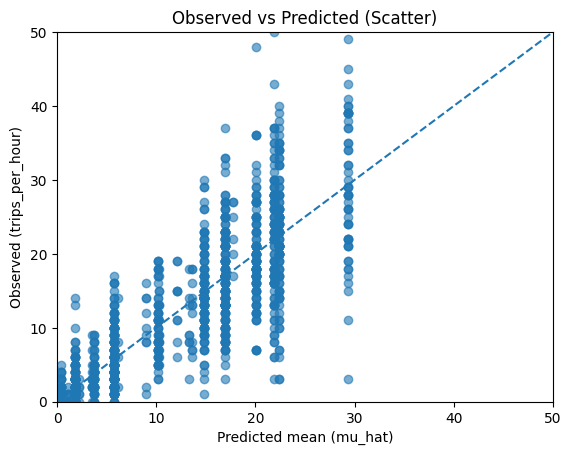

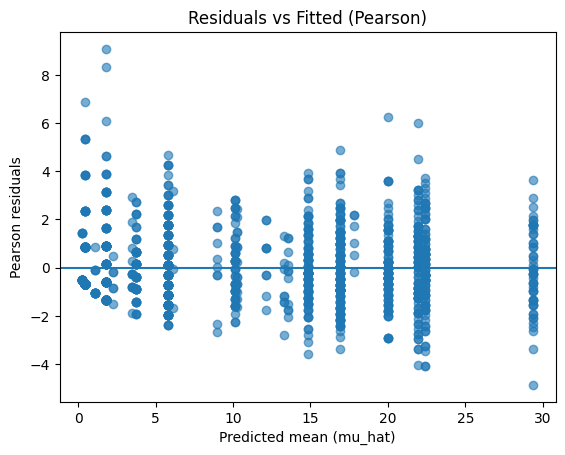

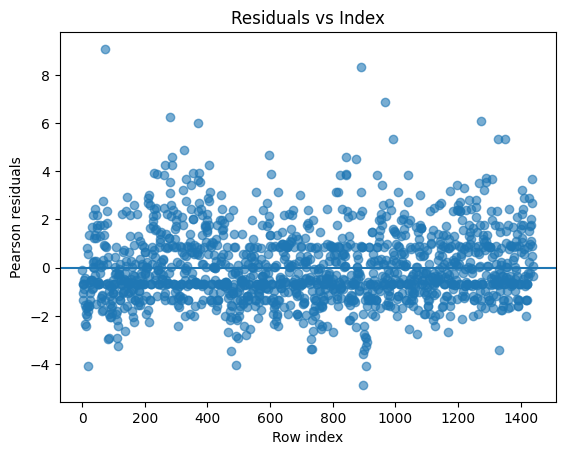

In [65]:
model3b_rain_event_spec = {
    "name": "Model 3b — Weekdays + 12-hour segmentation + rain_event (0/1)",
    "weekday_only": True,
    "no_rain_only": False,

    "hour_seg": optimized_12segment_spec["hour_seg"],

    "terms": [
        "C(daytime_segment)",
        "C(rain_event)"
    ],

    "cov_type": "HC0",
    "plots": True,
    "axis_max": GLOBAL_AXIS_MAX,
}

out_m3b = run_poisson_model(base_df, model3b_rain_event_spec)


### Model 3c - rain ([0-5,5+]mm)


MODEL: Model 3c — Weekdays + 12-hour segmentation + rain bins (0 / 0-5 / 5+)
Formula: trips_per_hour ~ C(daytime_segment) + C(rain_segment)
N rows: 1441
Dispersion (Pearson Chi2 / df_resid): 2.3017

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1441
Model:                            GLM   Df Residuals:                     1427
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4033.1
Date:                Tue, 13 Jan 2026   Deviance:                       3215.8
Time:                        03:06:29   Pearson chi2:                 3.28e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9998
Covariance Type:                  HC0                                         
          

coef   std_err          z  \
term                                                                   
Intercept                              0.590787  0.099634   5.929585   
C(daytime_segment)[T.early_morning]   -1.407544  0.157628  -8.929539   
C(daytime_segment)[T.morning_rush]     0.726123  0.126447   5.742528   
C(daytime_segment)[T.peak_morning]     2.106477  0.107554  19.585367   
C(daytime_segment)[T.mid_morning]      2.789742  0.107796  25.879933   
C(daytime_segment)[T.late_morning]     2.496768  0.105161  23.742263   
C(daytime_segment)[T.early_afternoon]  2.237249  0.103284  21.661047   
C(daytime_segment)[T.mid_afternoon]    2.405043  0.103986  23.128586   
C(daytime_segment)[T.late_afternoon]   2.518302  0.104353  24.132449   
C(daytime_segment)[T.early_evening]    2.106906  0.114590  18.386472   
C(daytime_segment)[T.evening]          1.725269  0.115114  14.987482   
C(daytime_segment)[T.night]            1.165108  0.111346  10.463809   
C(rain_segment)[T.0-5]                -0.507535  0.050185 -10.113218   
C(rain_segment)[T.5+]                 -0.324657  0.230977  -1.405580   

                                             p_value    ci_low   ci_high  
term                                                                      
Intercept                               3.037009e-09  0.395508  0.786065  
C(daytime_segment)[T.early_morning]     4.277894e-19 -1.716489 -1.098599  
C(daytime_segment)[T.morning_rush]      9.327370e-09  0.478292  0.973953  
C(daytime_segment)[T.peak_morning]      2.061140e-85  1.895675  2.317278  
C(daytime_segment)[T.mid_morning]      1.120515e-147  2.578467  3.001018  
C(daytime_segment)[T.late_morning]     1.320752e-124  2.290655  2.702880  
C(daytime_segment)[T.early_afternoon]  4.782457e-104  2.034815  2.439683  
C(daytime_segment)[T.mid_afternoon]    2.388309e-118  2.201235  2.608852  
C(daytime_segment)[T.late_afternoon]   1.141426e-128  2.313773  2.722831  
C(daytime_segment)[T.early_evening]     1.686021e-75  1.882314  2.331498  
C(daytime_segment)[T.evening]           8.865027e-51  1.499649  1.950888  
C(daytime_segment)[T.night]             1.266599e-25  0.946873  1.383343  
C(rain_segment)[T.0-5]                  4.827215e-24 -0.605896 -0.409174  
C(rain_segment)[T.5+]                   1.598487e-01 -0.777365  0.128050

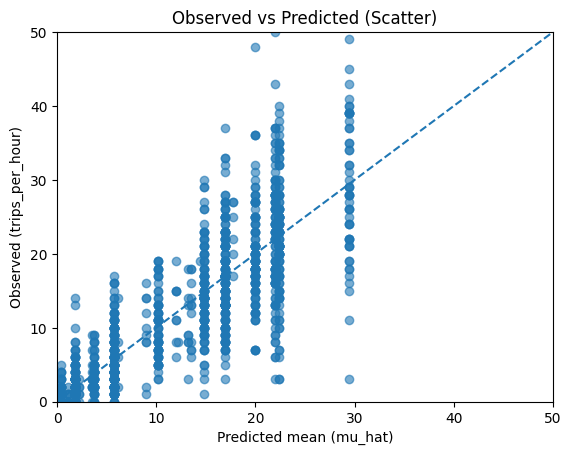

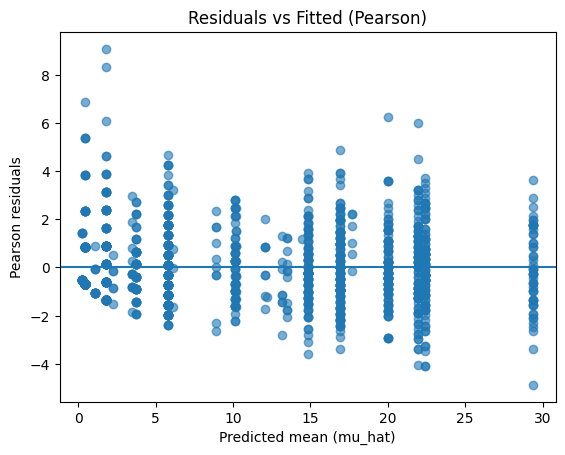

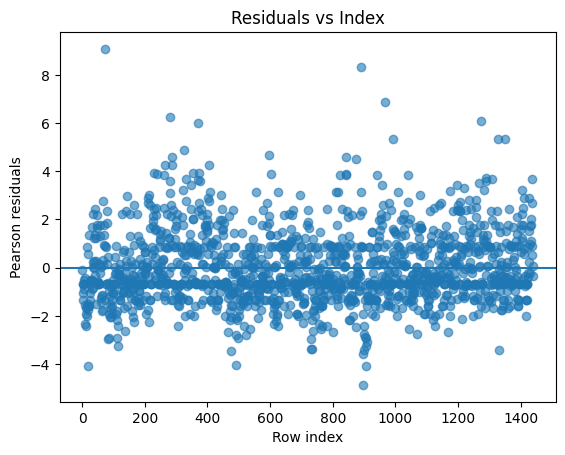

C:\Users\etaiw\AppData\Local\Temp\ipykernel_21796\1919046029.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_used[factor_col]):


level_i level_j  effect_log        se          z         p_raw       IRR  \
0       0     0-5    0.507535  0.050185  10.113218  4.827215e-24  1.661191   
1       0      5+    0.324657  0.230977   1.405580  1.598487e-01  1.383557   
2     0-5      5+   -0.182878  0.235742  -0.775754  4.378945e-01  0.832870   

   IRR_ci_low  IRR_ci_high         p_adj  reject_0.05  
0    1.505570     1.832898  1.448164e-23         True  
1    0.879802     2.175749  3.196975e-01        False  
2    0.524698     1.322041  4.378945e-01        False

In [66]:
model3c_rain_5mm_spec = {
    "name": "Model 3c — Weekdays + 12-hour segmentation + rain bins (0 / 0-5 / 5+)",
    "weekday_only": True,
    "no_rain_only": False,

    "hour_seg": optimized_12segment_spec["hour_seg"],

    "rain_seg": {
        "rain_col": "rain_mm",
        "out_col": "rain_segment",
        "edges": [-0.001, 0, 5, np.inf],
        "labels": ["0", "0-5", "5+"]
    },

    "terms": [
        "C(daytime_segment)",
        "C(rain_segment)"
    ],

    "cov_type": "HC0",
    "plots": True,
    "axis_max": GLOBAL_AXIS_MAX,

    # Post-hoc כאן אפשרי (למרות שיש 3 רמות בלבד)
    "posthoc": {
        "factor_col": "rain_segment",
        "correction": "holm"
    }
}

out_m3c = run_poisson_model(base_df, model3c_rain_5mm_spec)


### post-hoc 


MODEL: Model 3d — Weekdays + 12-hour segmentation + rain segmented (initial multi-bins)
Formula: trips_per_hour ~ C(daytime_segment) + C(rain_segment)
N rows: 1441
Dispersion (Pearson Chi2 / df_resid): 2.2882

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1441
Model:                            GLM   Df Residuals:                     1425
Model Family:                 Poisson   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4021.7
Date:                Tue, 13 Jan 2026   Deviance:                       3192.9
Time:                        03:07:39   Pearson chi2:                 3.26e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9998
Covariance Type:                  HC0                                         

coef   std_err          z  \
term                                                                   
Intercept                              0.589475  0.099698   5.912576   
C(daytime_segment)[T.early_morning]   -1.403686  0.157664  -8.903035   
C(daytime_segment)[T.morning_rush]     0.728976  0.126496   5.762863   
C(daytime_segment)[T.peak_morning]     2.109571  0.107562  19.612667   
C(daytime_segment)[T.mid_morning]      2.785361  0.107738  25.853101   
C(daytime_segment)[T.late_morning]     2.503570  0.105163  23.806503   
C(daytime_segment)[T.early_afternoon]  2.237255  0.103331  21.651404   
C(daytime_segment)[T.mid_afternoon]    2.404668  0.104015  23.118473   
C(daytime_segment)[T.late_afternoon]   2.518599  0.104442  24.114728   
C(daytime_segment)[T.early_evening]    2.109551  0.114636  18.402245   
C(daytime_segment)[T.evening]          1.731151  0.115356  15.006987   
C(daytime_segment)[T.night]            1.166510  0.111416  10.469888   
C(rain_segment)[T.0-1]                -0.420376  0.050587  -8.309924   
C(rain_segment)[T.1-3]                -0.881930  0.114619  -7.694422   
C(rain_segment)[T.3-5]                -0.729959  0.124688  -5.854303   
C(rain_segment)[T.5+]                 -0.323193  0.231113  -1.398420   

                                             p_value    ci_low   ci_high  
term                                                                      
Intercept                               3.367992e-09  0.394069  0.784880  
C(daytime_segment)[T.early_morning]     5.434018e-19 -1.712701 -1.094671  
C(daytime_segment)[T.morning_rush]      8.269884e-09  0.481050  0.976903  
C(daytime_segment)[T.peak_morning]      1.205411e-85  1.898754  2.320388  
C(daytime_segment)[T.mid_morning]      2.245411e-147  2.574198  2.996523  
C(daytime_segment)[T.late_morning]     2.860076e-125  2.297454  2.709686  
C(daytime_segment)[T.early_afternoon]  5.895675e-104  2.034730  2.439779  
C(daytime_segment)[T.mid_afternoon]    3.018812e-118  2.200802  2.608533  
C(daytime_segment)[T.late_afternoon]   1.751586e-128  2.313896  2.723303  
C(daytime_segment)[T.early_evening]     1.260337e-75  1.884870  2.334233  
C(daytime_segment)[T.evening]           6.608247e-51  1.505057  1.957245  
C(daytime_segment)[T.night]             1.187835e-25  0.948139  1.384880  
C(rain_segment)[T.0-1]                  9.576340e-17 -0.519525 -0.321227  
C(rain_segment)[T.1-3]                  1.421350e-14 -1.106580 -0.657280  
C(rain_segment)[T.3-5]                  4.790146e-09 -0.974343 -0.485576  
C(rain_segment)[T.5+]                   1.619870e-01 -0.776166  0.129780

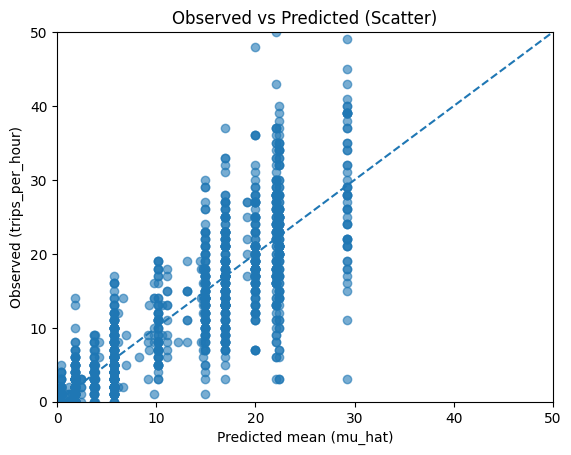

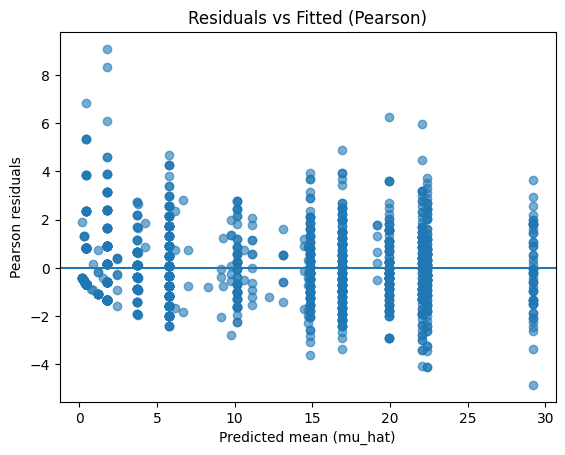

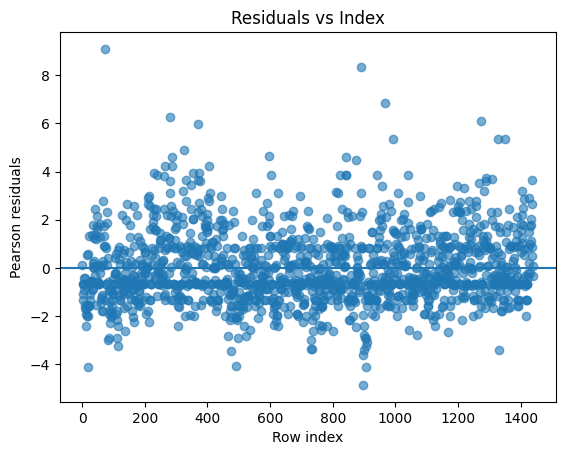

C:\Users\etaiw\AppData\Local\Temp\ipykernel_21796\1919046029.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_used[factor_col]):


level_i level_j  effect_log        se         z         p_raw       IRR  \
0       0     0-1    0.420376  0.050587  8.309924  9.576340e-17  1.522533   
1       0     1-3    0.881930  0.114619  7.694422  1.421350e-14  2.415557   
2       0     3-5    0.729959  0.124688  5.854303  4.790146e-09  2.074996   
4     0-1     1-3    0.461554  0.124392  3.710486  2.068618e-04  1.586538   
5     0-1     3-5    0.309584  0.133730  2.314981  2.061396e-02  1.362857   
8     1-3      5+   -0.558737  0.257485 -2.169978  3.000851e-02  0.571931   
9     3-5      5+   -0.406766  0.262562 -1.549220  1.213289e-01  0.665800   
3       0      5+    0.323193  0.231113  1.398420  1.619870e-01  1.381532   
7     1-3     3-5   -0.151971  0.167722 -0.906088  3.648895e-01  0.859014   
6     0-1      5+   -0.097183  0.235860 -0.412036  6.803131e-01  0.907390   

   IRR_ci_low  IRR_ci_high         p_adj  reject_0.05  
0    1.378816     1.681232  9.576340e-16         True  
1    1.929529     3.024010  1.279215e-13         True  
2    1.625103     2.649437  3.832117e-08         True  
4    1.243271     2.024580  1.448032e-03         True  
5    1.048617     1.771267  1.236837e-01        False  
8    0.345277     0.947369  1.500425e-01        False  
9    0.397966     1.113887  4.853158e-01        False  
3    0.878281     2.173142  4.859610e-01        False  
7    0.618347     1.193350  7.297790e-01        False  
6    0.571512     1.440663  7.297790e-01        False

In [67]:
model3d_rain_multi_spec = {
    "name": "Model 3d — Weekdays + 12-hour segmentation + rain segmented (initial multi-bins)",
    "weekday_only": True,
    "no_rain_only": False,

    "hour_seg": optimized_12segment_spec["hour_seg"],

    "rain_seg": {
        "rain_col": "rain_mm",
        "out_col": "rain_segment",
        "edges": [-0.001, 0, 1, 3, 5, np.inf],
        "labels": ["0", "0-1", "1-3", "3-5", "5+"]
    },

    "terms": [
        "C(daytime_segment)",
        "C(rain_segment)"
    ],

    "cov_type": "HC0",
    "plots": True,
    "axis_max": GLOBAL_AXIS_MAX,

    "posthoc": {
        "factor_col": "rain_segment",
        "correction": "holm"
    }
}

out_m3d = run_poisson_model(base_df, model3d_rain_multi_spec)


In [68]:
df_tmp = build_model_dataset(base_df, model3d_rain_multi_spec)
display(df_tmp["rain_segment"].value_counts(dropna=False))


rain_segment
0      1316
0-1      90
1-3      26
3-5       6
5+        3
Name: count, dtype: int64


MODEL: Model 3d(v2) — rain bins updated
Formula: trips_per_hour ~ C(daytime_segment) + C(rain_segment)
N rows: 1441
Dispersion (Pearson Chi2 / df_resid): 2.3014

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1441
Model:                            GLM   Df Residuals:                     1426
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4032.5
Date:                Tue, 13 Jan 2026   Deviance:                       3214.4
Time:                        03:08:30   Pearson chi2:                 3.28e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9998
Covariance Type:                  HC0                                         
                                            coe

coef   std_err          z  \
term                                                                   
Intercept                              0.591776  0.099632   5.939585   
C(daytime_segment)[T.early_morning]   -1.408599  0.157631  -8.936044   
C(daytime_segment)[T.morning_rush]     0.726765  0.126446   5.747650   
C(daytime_segment)[T.peak_morning]     2.104884  0.107566  19.568327   
C(daytime_segment)[T.mid_morning]      2.788239  0.107802  25.864519   
C(daytime_segment)[T.late_morning]     2.497557  0.105159  23.750269   
C(daytime_segment)[T.early_afternoon]  2.235891  0.103297  21.645292   
C(daytime_segment)[T.mid_afternoon]    2.403713  0.103998  23.113006   
C(daytime_segment)[T.late_afternoon]   2.516844  0.104377  24.112914   
C(daytime_segment)[T.early_evening]    2.105665  0.114594  18.375020   
C(daytime_segment)[T.evening]          1.723942  0.115112  14.976217   
C(daytime_segment)[T.night]            1.163752  0.111361  10.450254   
C(rain_segment)[T.0-3]                -0.499366  0.051392  -9.716863   
C(rain_segment)[T.3-5]                -0.726950  0.124829  -5.823554   
C(rain_segment)[T.5+]                 -0.324307  0.230969  -1.404113   

                                             p_value    ci_low   ci_high  
term                                                                      
Intercept                               2.857452e-09  0.396500  0.787052  
C(daytime_segment)[T.early_morning]     4.033513e-19 -1.717550 -1.099647  
C(daytime_segment)[T.morning_rush]      9.049216e-09  0.478936  0.974594  
C(daytime_segment)[T.peak_morning]      2.879824e-85  1.894059  2.315709  
C(daytime_segment)[T.mid_morning]      1.670594e-147  2.576952  2.999527  
C(daytime_segment)[T.late_morning]     1.091725e-124  2.291449  2.703665  
C(daytime_segment)[T.early_afternoon]  6.731547e-104  2.033433  2.438349  
C(daytime_segment)[T.mid_afternoon]    3.426277e-118  2.199880  2.607546  
C(daytime_segment)[T.late_afternoon]   1.830014e-128  2.312268  2.721420  
C(daytime_segment)[T.early_evening]     2.082318e-75  1.881065  2.330265  
C(daytime_segment)[T.evening]           1.050270e-50  1.498326  1.949557  
C(daytime_segment)[T.night]             1.461339e-25  0.945488  1.382015  
C(rain_segment)[T.0-3]                  2.555328e-22 -0.600091 -0.398640  
C(rain_segment)[T.3-5]                  5.760927e-09 -0.971611 -0.482289  
C(rain_segment)[T.5+]                   1.602853e-01 -0.776998  0.128385

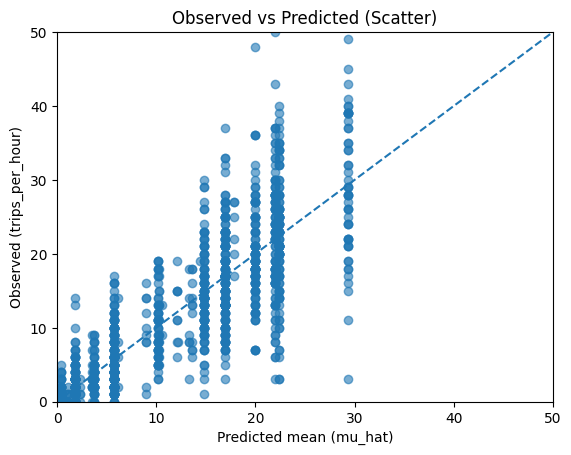

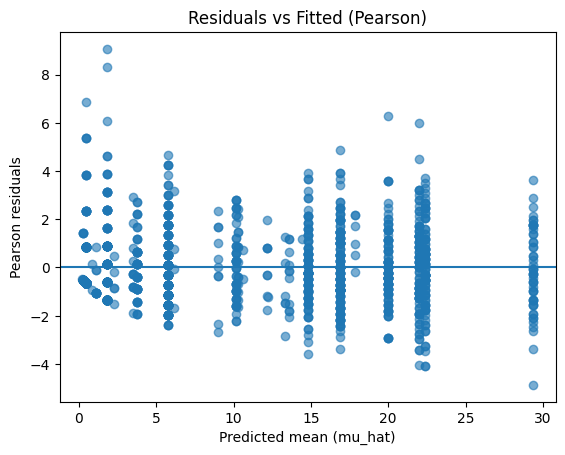

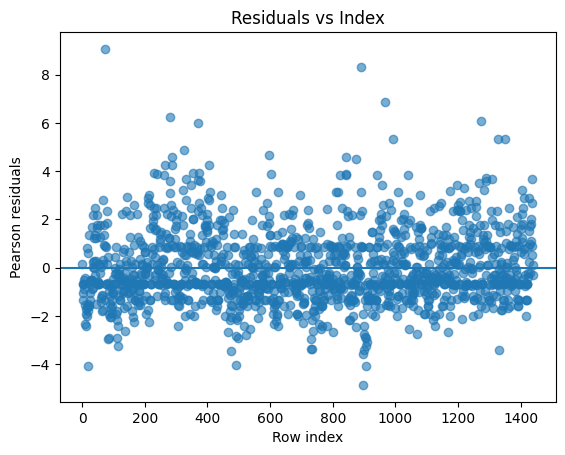

C:\Users\etaiw\AppData\Local\Temp\ipykernel_21796\1919046029.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_used[factor_col]):


level_i level_j  effect_log        se         z         p_raw       IRR  \
0       0     0-3    0.499366  0.051392  9.716863  2.555328e-22  1.647676   
1       0     3-5    0.726950  0.124829  5.823554  5.760927e-09  2.068761   
3     0-3     3-5    0.227584  0.134099  1.697134  8.967136e-02  1.255563   
5     3-5      5+   -0.402643  0.262507 -1.533836  1.250700e-01  0.668551   
2       0      5+    0.324307  0.230969  1.404113  1.602853e-01  1.383072   
4     0-3      5+   -0.175059  0.235956 -0.741913  4.581398e-01  0.839408   

   IRR_ci_low  IRR_ci_high         p_adj  reject_0.05  
0    1.489794     1.822289  1.533197e-21         True  
1    1.619771     2.642209  2.880463e-08         True  
3    0.965364     1.633000  3.586854e-01        False  
5    0.399653     1.118369  3.752101e-01        False  
2    0.879508     2.174952  3.752101e-01        False  
4    0.528595     1.332977  4.581398e-01        False

In [69]:
model3d_rain_multi_v2_spec = {
    **model3d_rain_multi_spec,
    "name": "Model 3d(v2) — rain bins updated",
    "rain_seg": {
        "rain_col": "rain_mm",
        "out_col": "rain_segment",
        "edges": [-0.001, 0, 3, 5, np.inf],
        "labels": ["0", "0-3", "3-5", "5+"]
    }
}

out_m3d_v2 = run_poisson_model(base_df, model3d_rain_multi_v2_spec)


# Rain


MODEL: Model 4 — 12-Segment with Rain (Continuous)
Formula: trips_per_hour ~ C(daytime_segment) + temp_c + wind_speed_ms + rain_mm
N rows: 1441
Dispersion (Pearson Chi2 / df_resid): 2.3323

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1441
Model:                            GLM   Df Residuals:                     1426
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4034.1
Date:                Tue, 13 Jan 2026   Deviance:                       3217.8
Time:                        03:03:59   Pearson chi2:                 3.33e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9998
Covariance Type:                  HC0                                         
                   

coef   std_err          z  \
term                                                                   
Intercept                              0.286042  0.117358   2.437349   
C(daytime_segment)[T.early_morning]   -1.385479  0.156860  -8.832603   
C(daytime_segment)[T.morning]          0.752902  0.127817   5.890483   
C(daytime_segment)[T.peak_morning]     2.100431  0.107373  19.561915   
C(daytime_segment)[T.mid_morning]      2.751247  0.106618  25.804674   
C(daytime_segment)[T.early_afternoon]  2.449565  0.106156  23.075132   
C(daytime_segment)[T.mid_afternoon]    2.175969  0.104571  20.808446   
C(daytime_segment)[T.late_afternoon]   2.349203  0.106298  22.100257   
C(daytime_segment)[T.early_evening]    2.463258  0.105493  23.349861   
C(daytime_segment)[T.evening]          2.063380  0.114580  18.008147   
C(daytime_segment)[T.late_evening]     1.678839  0.115301  14.560445   
C(daytime_segment)[T.midnight]         1.131923  0.111191  10.179999   
temp_c                                 0.026171  0.004705   5.561960   
wind_speed_ms                         -0.023794  0.004744  -5.015686   
rain_mm                               -0.155355  0.112924  -1.375749   

                                             p_value    ci_low   ci_high  
term                                                                      
Intercept                               1.479539e-02  0.056025  0.516058  
C(daytime_segment)[T.early_morning]     1.022678e-18 -1.692918 -1.078040  
C(daytime_segment)[T.morning]           3.850680e-09  0.502386  1.003418  
C(daytime_segment)[T.peak_morning]      3.265775e-85  1.889983  2.310879  
C(daytime_segment)[T.mid_morning]      7.858195e-147  2.542279  2.960214  
C(daytime_segment)[T.early_afternoon]  8.229887e-118  2.241503  2.657628  
C(daytime_segment)[T.mid_afternoon]     3.629215e-96  1.971013  2.380925  
C(daytime_segment)[T.late_afternoon]   3.142766e-108  2.140863  2.557542  
C(daytime_segment)[T.early_evening]    1.382633e-120  2.256495  2.670021  
C(daytime_segment)[T.evening]           1.681644e-72  1.838806  2.287953  
C(daytime_segment)[T.late_evening]      5.013026e-48  1.452852  1.904825  
C(daytime_segment)[T.midnight]          2.435628e-24  0.913993  1.349853  
temp_c                                  2.667622e-08  0.016949  0.035394  
wind_speed_ms                           5.284448e-07 -0.033092 -0.014496  
rain_mm                                 1.688994e-01 -0.376683  0.065972

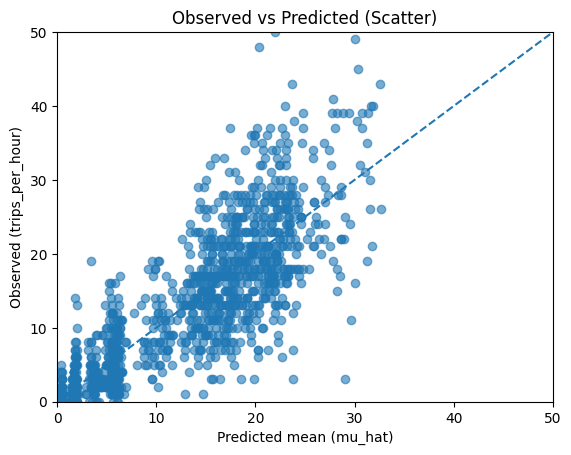

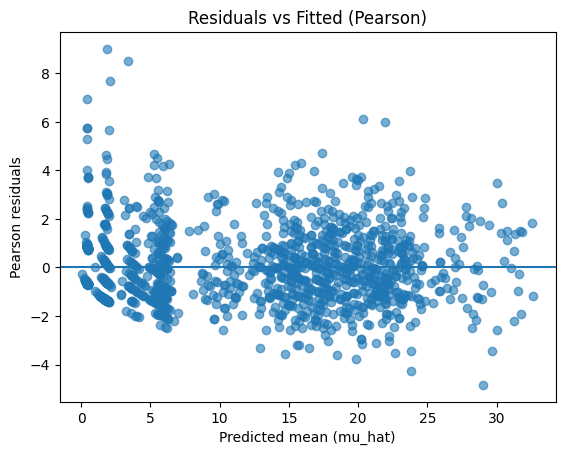

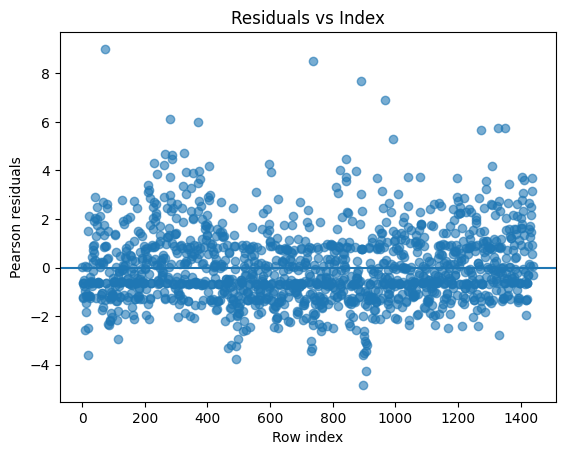

In [56]:
# Model with Rain as Continuous Variable
model_rain_continuous_spec = {
    "name": "Model 4 — 12-Segment with Rain (Continuous)",
    
    # Same filters as your optimal routine model
    "weekday_only": True,     # Sun–Thu (weekend==0)
    "no_rain_only": False,    # NOW INCLUDING RAIN DAYS!
    
    # Use your optimized 12-segment configuration
    "hour_seg": {
        "hour_col": "hour",
        "out_col": "daytime_segment", 
        "edges": [0, 2, 6, 7, 8, 9, 11, 14, 16, 18, 19, 20, 24],
        "labels": ["early_early", "early_morning", "morning", "peak_morning", 
                   "mid_morning", "early_afternoon", "mid_afternoon", "late_afternoon", 
                   "early_evening", "evening", "late_evening", "midnight"]
    },
    
    # Model terms - ADD rain_mm as continuous
    "terms": [
        "C(daytime_segment)",  # Your 12 optimized segments
        "temp_c",              # Temperature
        "wind_speed_ms",       # Wind speed
        "rain_mm"              # RAIN AS CONTINUOUS VARIABLE
    ],
    
    # Technical settings
    "cov_type": "HC0",
    "plots": True,
    "axis_max": GLOBAL_AXIS_MAX,
    
    # Post-hoc will be on rain segments (next step)
    "posthoc": None  # We'll do this separately
}

# Run the model
out_rain_continuous = run_poisson_model(base_df, model_rain_continuous_spec)

In [57]:
# Extract rain coefficient and significance
rain_results = out_rain_continuous['results']
rain_coef = rain_results.params['rain_mm']
rain_pval = rain_results.pvalues['rain_mm']
rain_ci = rain_results.conf_int().loc['rain_mm']

print("Rain Variable Analysis:")
print(f"Coefficient: {rain_coef:.4f}")
print(f"p-value: {rain_pval:.4f}")
print(f"95% CI: [{rain_ci[0]:.4f}, {rain_ci[1]:.4f}]")
print(f"IRR (per 1mm rain): {np.exp(rain_coef):.4f}")

if rain_pval < 0.05:
    print("✅ Rain is statistically significant")
    direction = "increases" if rain_coef < 0 else "decreases"
    print(f"   Each mm of rain {direction} trip probability by {abs(np.exp(rain_coef)-1)*100:.1f}%")
else:
    print("❌ Rain is not statistically significant")

Rain Variable Analysis:
Coefficient: -0.1554
p-value: 0.1689
95% CI: [-0.3767, 0.0660]
IRR (per 1mm rain): 0.8561
❌ Rain is not statistically significant



MODEL: Model 5 — Rain Segmentation Analysis
Formula: trips_per_hour ~ C(daytime_segment) + C(rain_segment) + temp_c + wind_speed_ms
N rows: 1441
Dispersion (Pearson Chi2 / df_resid): 2.2313

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1441
Model:                            GLM   Df Residuals:                     1424
Model Family:                 Poisson   Df Model:                           16
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3983.0
Date:                Tue, 13 Jan 2026   Deviance:                       3115.5
Time:                        03:03:59   Pearson chi2:                 3.18e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9998
Covariance Type:                  HC0                                         
                  

coef   std_err          z  \
term                                                                   
Intercept                              0.369749  0.115319   3.206331   
C(daytime_segment)[T.early_morning]   -1.383907  0.156520  -8.841730   
C(daytime_segment)[T.morning]          0.751089  0.126423   5.941102   
C(daytime_segment)[T.peak_morning]     2.114005  0.106604  19.830511   
C(daytime_segment)[T.mid_morning]      2.762590  0.106693  25.892957   
C(daytime_segment)[T.early_afternoon]  2.461415  0.105474  23.336629   
C(daytime_segment)[T.mid_afternoon]    2.191431  0.104258  21.019213   
C(daytime_segment)[T.late_afternoon]   2.359752  0.105944  22.273679   
C(daytime_segment)[T.early_evening]    2.480468  0.105142  23.591534   
C(daytime_segment)[T.evening]          2.072208  0.114566  18.087470   
C(daytime_segment)[T.late_evening]     1.692885  0.115425  14.666499   
C(daytime_segment)[T.midnight]         1.141117  0.110988  10.281432   
C(rain_segment)[T.0-1mm]              -0.317694  0.050815  -6.251957   
C(rain_segment)[T.1-3mm]              -0.795505  0.115172  -6.907094   
C(rain_segment)[T.3mm+]               -0.501245  0.165815  -3.022920   
temp_c                                 0.020099  0.004520   4.446358   
wind_speed_ms                         -0.019134  0.004549  -4.206203   

                                             p_value    ci_low   ci_high  
term                                                                      
Intercept                               1.344393e-03  0.143729  0.595770  
C(daytime_segment)[T.early_morning]     9.424790e-19 -1.690681 -1.077134  
C(daytime_segment)[T.morning]           2.831130e-09  0.503305  0.998873  
C(daytime_segment)[T.peak_morning]      1.623833e-87  1.905065  2.322944  
C(daytime_segment)[T.mid_morning]      7.994333e-148  2.553476  2.971703  
C(daytime_segment)[T.early_afternoon]  1.884082e-120  2.254689  2.668141  
C(daytime_segment)[T.mid_afternoon]     4.376320e-98  1.987088  2.395773  
C(daytime_segment)[T.late_afternoon]   6.650983e-110  2.152106  2.567397  
C(daytime_segment)[T.early_evening]    4.707974e-123  2.274393  2.686543  
C(daytime_segment)[T.evening]           4.000345e-73  1.847663  2.296753  
C(daytime_segment)[T.late_evening]      1.056579e-48  1.466656  1.919115  
C(daytime_segment)[T.midnight]          8.544852e-25  0.923585  1.358650  
C(rain_segment)[T.0-1mm]                4.053407e-10 -0.417290 -0.218098  
C(rain_segment)[T.1-3mm]                4.946811e-12 -1.021239 -0.569772  
C(rain_segment)[T.3mm+]                 2.503484e-03 -0.826236 -0.176254  
temp_c                                  8.733844e-06  0.011239  0.028958  
wind_speed_ms                           2.596971e-05 -0.028050 -0.010218

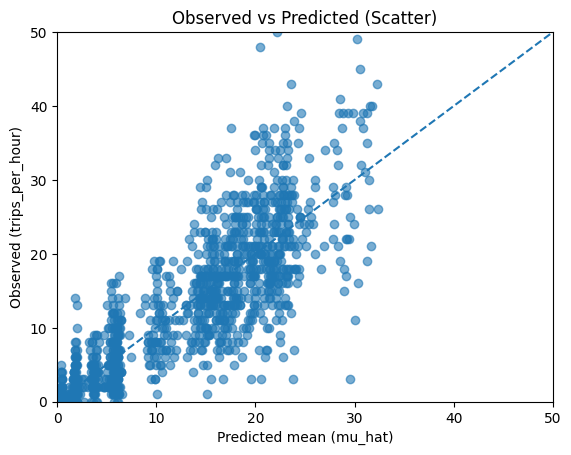

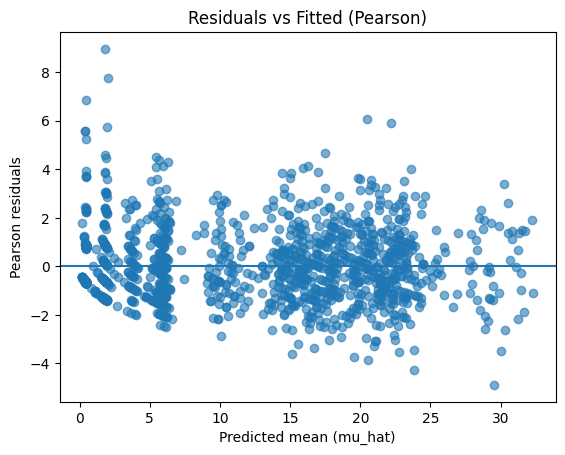

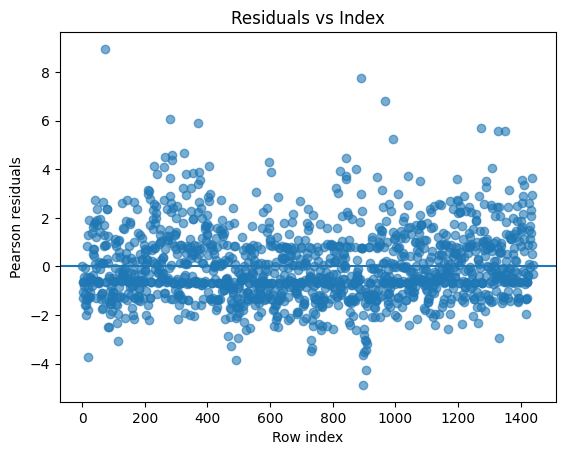

C:\Users\etaiw\AppData\Local\Temp\ipykernel_21796\1919046029.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_used[factor_col]):


level_i level_j  effect_log        se         z         p_raw       IRR  \
1     0mm   1-3mm    0.795505  0.115172  6.907094  4.946811e-12  2.215560   
0     0mm   0-1mm    0.317694  0.050815  6.251957  4.053407e-10  1.373956   
3   0-1mm   1-3mm    0.477811  0.122972  3.885519  1.021115e-04  1.612541   
2     0mm    3mm+    0.501245  0.165815  3.022920  2.503484e-03  1.650776   
5   1-3mm    3mm+   -0.294260  0.199935 -1.471781  1.410799e-01  0.745083   
4   0-1mm    3mm+    0.183551  0.171955  1.067435  2.857756e-01  1.201476   

   IRR_ci_low  IRR_ci_high         p_adj  reject_0.05  
1    1.767856     2.776643  2.968086e-11         True  
0    1.243707     1.517846  2.026704e-09         True  
3    1.267169     2.052044  4.084459e-04         True  
2    1.192734     2.284718  7.510453e-03         True  
5    0.503520     1.102535  2.821598e-01        False  
4    0.857717     1.683009  2.857756e-01        False

In [58]:
# Model for Rain Post-Hoc Analysis
model_rain_posthoc_spec = {
    "name": "Model 5 — Rain Segmentation Analysis",
    
    # Same filters
    "weekday_only": True,
    "no_rain_only": False,
    
    # Use 12-segments again
    "hour_seg": {
        "hour_col": "hour",
        "out_col": "daytime_segment", 
        "edges": [0, 2, 6, 7, 8, 9, 11, 14, 16, 18, 19, 20, 24],
        "labels": ["early_early", "early_morning", "morning", "peak_morning", 
                   "mid_morning", "early_afternoon", "mid_afternoon", "late_afternoon", 
                   "early_evening", "evening", "late_evening", "midnight"]
    },
    
    # Create rain segments for post-hoc
    "rain_seg": {
        "rain_col": "rain_mm",
        "out_col": "rain_segment",
        "edges": [-0.001, 0, 1, 3, np.inf],  # 0mm, 0-1mm, 1-3mm, 3mm+
        "labels": ["0mm", "0-1mm", "1-3mm", "3mm+"]
    },
    
    # Model terms
    "terms": [
        "C(daytime_segment)",  # 12 segments
        "C(rain_segment)",     # Rain categories
        "temp_c",
        "wind_speed_ms"
    ],
    
    # Technical settings
    "cov_type": "HC0",
    "plots": True,
    "axis_max": GLOBAL_AXIS_MAX,
    
    # Post-hoc on rain segments (like you did for hours)
    "posthoc": {
        "factor_col": "rain_segment",
        "correction": "holm"
    }
}

# Run the model
out_rain_posthoc = run_poisson_model(base_df, model_rain_posthoc_spec)

In [59]:
# =================================================
# STEP 3.4: ANALYZE RAIN POST-HOC RESULTS
# =================================================

print("RAIN SEGMENTATION POST-HOC ANALYSIS")
print("=" * 50)

# Get post-hoc results
rain_posthoc = out_rain_posthoc["posthoc"]

# Most significant rain differences
most_sig_rain = rain_posthoc.sort_values('p_adj').head(10)
print("Most significant rain category differences:")
print(most_sig_rain[['level_i', 'level_j', 'IRR', 'p_adj', 'reject_0.05']].to_string())

# Extreme differences
extreme_rain = rain_posthoc[(rain_posthoc['IRR'] < 0.5) | (rain_posthoc['IRR'] > 2.0)]
print(f"\nExtreme rain differences (IRR < 0.5 or > 2.0): {len(extreme_rain)} found")

# Similar rain categories
similar_rain = rain_posthoc[
    (~rain_posthoc['reject_0.05']) & 
    (rain_posthoc['IRR'].between(0.8, 1.25))
]
print(f"Similar rain pairs (IRR 0.8-1.25, not significant): {len(similar_rain)} found")

# Check which boundaries are meaningful
print("Rain Segmentation Insights:")
if len(extreme_rain) > 0:
    print("• Clear boundaries exist between rain categories")
    print("• Some rain amounts have very different trip patterns")
else:
    print("• Rain categories are relatively similar")
    print("• May not need complex rain segmentation")

# Compare with no-rain baseline
rain_coefs = out_rain_posthoc['results'].params
rain_baseline = rain_coefs['Intercept']  # This is the 0mm category

print("Rain Impact Summary:")
for cat in ["0-1mm", "1-3mm", "3mm+"]:
    if f"C(rain_segment)[T.{cat}]" in rain_coefs.index:
        coef = rain_coefs[f"C(rain_segment)[T.{cat}]"]
        irr = np.exp(coef)
        percent_change = (irr - 1) * 100
        print(f"  {cat} vs 0mm: {percent_change:+.1f}% trips (IRR={irr:.3f})")

RAIN SEGMENTATION POST-HOC ANALYSIS
Most significant rain category differences:
  level_i level_j       IRR         p_adj  reject_0.05
1     0mm   1-3mm  2.215560  2.968086e-11         True
0     0mm   0-1mm  1.373956  2.026704e-09         True
3   0-1mm   1-3mm  1.612541  4.084459e-04         True
2     0mm    3mm+  1.650776  7.510453e-03         True
5   1-3mm    3mm+  0.745083  2.821598e-01        False
4   0-1mm    3mm+  1.201476  2.857756e-01        False

Extreme rain differences (IRR < 0.5 or > 2.0): 1 found
Similar rain pairs (IRR 0.8-1.25, not significant): 1 found
Rain Segmentation Insights:
• Clear boundaries exist between rain categories
• Some rain amounts have very different trip patterns
Rain Impact Summary:
  0-1mm vs 0mm: -27.2% trips (IRR=0.728)
  1-3mm vs 0mm: -54.9% trips (IRR=0.451)
  3mm+ vs 0mm: -39.4% trips (IRR=0.606)



MODEL: Final Model — 12-Segment Hours + Optimized Rain Categories
Formula: trips_per_hour ~ C(daytime_segment) + C(rain_segment) + temp_c + wind_speed_ms
N rows: 1441
Dispersion (Pearson Chi2 / df_resid): 2.2835

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1441
Model:                            GLM   Df Residuals:                     1426
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4015.8
Date:                Tue, 13 Jan 2026   Deviance:                       3181.1
Time:                        03:04:00   Pearson chi2:                 3.26e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9998
Covariance Type:                  HC0                                      

coef   std_err          z  \
term                                                                   
Intercept                              0.291034  0.115313   2.523871   
C(daytime_segment)[T.early_morning]   -1.384742  0.156848  -8.828550   
C(daytime_segment)[T.morning]          0.756065  0.127890   5.911847   
C(daytime_segment)[T.peak_morning]     2.108621  0.107246  19.661519   
C(daytime_segment)[T.mid_morning]      2.746846  0.106695  25.744902   
C(daytime_segment)[T.early_afternoon]  2.457389  0.105886  23.207855   
C(daytime_segment)[T.mid_afternoon]    2.176866  0.104552  20.820809   
C(daytime_segment)[T.late_afternoon]   2.347012  0.106365  22.065742   
C(daytime_segment)[T.early_evening]    2.464916  0.105541  23.355145   
C(daytime_segment)[T.evening]          2.066208  0.114702  18.013775   
C(daytime_segment)[T.late_evening]     1.686810  0.115501  14.604303   
C(daytime_segment)[T.midnight]         1.134134  0.111234  10.195910   
C(rain_segment)[T.1mm+]               -0.675653  0.103314  -6.539784   
temp_c                                 0.025864  0.004465   5.792920   
wind_speed_ms                         -0.024149  0.004590  -5.261309   

                                             p_value    ci_low   ci_high  
term                                                                      
Intercept                               1.160706e-02  0.065026  0.517043  
C(daytime_segment)[T.early_morning]     1.060414e-18 -1.692158 -1.077325  
C(daytime_segment)[T.morning]           3.382917e-09  0.505405  1.006724  
C(daytime_segment)[T.peak_morning]      4.607268e-86  1.898422  2.318819  
C(daytime_segment)[T.mid_morning]      3.676293e-146  2.537729  2.955964  
C(daytime_segment)[T.early_afternoon]  3.793290e-119  2.249856  2.664922  
C(daytime_segment)[T.mid_afternoon]     2.804122e-96  1.971947  2.381785  
C(daytime_segment)[T.late_afternoon]   6.745308e-108  2.138541  2.555483  
C(daytime_segment)[T.early_evening]    1.221855e-120  2.258060  2.671771  
C(daytime_segment)[T.evening]           1.519073e-72  1.841397  2.291018  
C(daytime_segment)[T.late_evening]      2.636641e-48  1.460432  1.913188  
C(daytime_segment)[T.midnight]          2.067984e-24  0.916119  1.352150  
C(rain_segment)[T.1mm+]                 6.160757e-11 -0.878145 -0.473161  
temp_c                                  6.917321e-09  0.017113  0.034614  
wind_speed_ms                           1.430338e-07 -0.033145 -0.015153

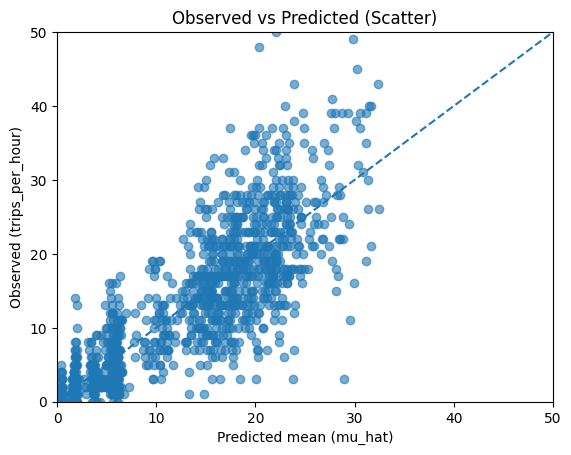

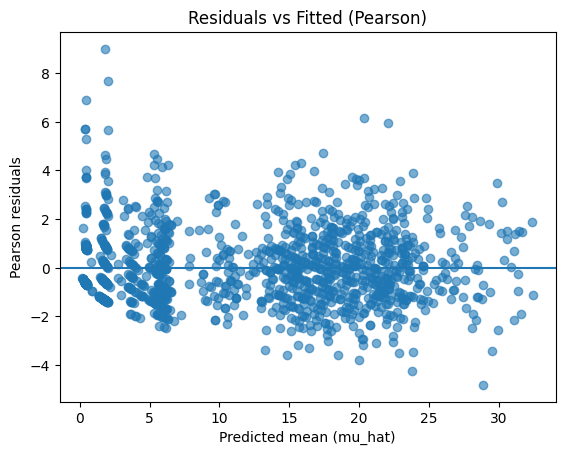

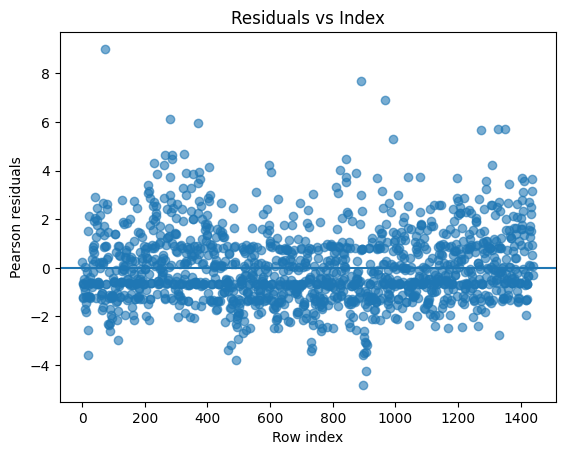


MODEL COMPARISON:
                  Model  Dispersion         Variables
     No Rain (baseline)    2.096000           weather
        Rain Continuous    2.332286         + rain_mm
Rain Categories (final)    2.283514 + rain_categories


In [60]:
# =================================================
# STEP 3.5: CREATE FINAL RAIN MODEL
# =================================================

# Based on post-hoc analysis, determine optimal rain boundaries
# Example: if 0mm vs 0-1mm are similar, but 1mm+ differs significantly

final_rain_model_spec = {
    "name": "Final Model — 12-Segment Hours + Optimized Rain Categories",
    
    "weekday_only": True,
    "no_rain_only": False,
    
    # Your optimized 12 hour segments
    "hour_seg": {
        "hour_col": "hour",
        "out_col": "daytime_segment", 
        "edges": [0, 2, 6, 7, 8, 9, 11, 14, 16, 18, 19, 20, 24],
        "labels": ["early_early", "early_morning", "morning", "peak_morning", 
                   "mid_morning", "early_afternoon", "mid_afternoon", "late_afternoon", 
                   "early_evening", "evening", "late_evening", "midnight"]
    },
    
    # Optimized rain segmentation based on post-hoc
    "rain_seg": {
        "rain_col": "rain_mm",
        "out_col": "rain_segment",
        "edges": [-0.001, 1, np.inf],  # Example: combine 0mm and 0-1mm if similar
        "labels": ["0-1mm", "1mm+"]    # Adjust based on your post-hoc findings
    },
    
    "terms": [
        "C(daytime_segment)",
        "C(rain_segment)",
        "temp_c",
        "wind_speed_ms"
    ],
    
    "cov_type": "HC0",
    "plots": True,
    "axis_max": GLOBAL_AXIS_MAX,
    
    "posthoc": None  # Final model doesn't need post-hoc
}

# Run final model
out_final_model = run_poisson_model(base_df, final_rain_model_spec)

# Compare performance
print("\nMODEL COMPARISON:")
comparison = pd.DataFrame({
    'Model': ['No Rain (baseline)', 'Rain Continuous', 'Rain Categories (final)'],
    'Dispersion': [2.096, out_rain_continuous['dispersion'], out_final_model['dispersion']],
    'Variables': ['weather', '+ rain_mm', '+ rain_categories']
})
print(comparison.to_string(index=False))

In [61]:
model_spec = {
    "name": "Model",

    # Filters (same routine definition)
    "weekday_only": True,     # Sun–Thu (weekend==0)
    "weekend_only": False,     # Sun–Thu (weekend==0)
    "no_rain_only": False,     # rain_mm == 0
    #"hour_range": [0, 23],    # Only hours 7-22 (7 AM to 10 PM)

    # Build hour categorical (24 levels)
    "hour_fe": True,

    # IMPORTANT: no rain_mm in the model terms
    "terms": [
        "C(hour_cat)",
        "temp_c",
        "wind_speed_ms",
        "rain_mm"
        # אפשר להוסיף עוד משתנים אם יש לך, כל עוד הם לא גשם
    ],

    "cov_type": "HC0",
    "plots": False,
    "plots_mode": "key",
    "axis_max": GLOBAL_AXIS_MAX,

    # Post hoc on 24-hour factor (for segmentation)
    "posthoc": {
        "factor_col": "hour_cat",
        "correction": "holm"
    }
}

out_model = run_poisson_model(base_df, model_spec, y_col="trips_per_hour")


MODEL: Model
Formula: trips_per_hour ~ C(hour_cat) + temp_c + wind_speed_ms + rain_mm
N rows: 1441
Dispersion (Pearson Chi2 / df_resid): 2.1366

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1441
Model:                            GLM   Df Residuals:                     1414
Model Family:                 Poisson   Df Model:                           26
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3920.6
Date:                Tue, 13 Jan 2026   Deviance:                       2990.8
Time:                        03:04:00   Pearson chi2:                 3.02e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.9998
Covariance Type:                  HC0                                         
                        coef    std err          z      P>|z|   

coef   std_err          z       p_value    ci_low  \
term                                                                       
Intercept          0.744594  0.144803   5.142111  2.716688e-07  0.460785   
C(hour_cat)[T.1]  -0.582141  0.203463  -2.861168  4.220838e-03 -0.980920   
C(hour_cat)[T.2]  -1.315830  0.242818  -5.418997  5.993425e-08 -1.791745   
C(hour_cat)[T.3]  -2.263342  0.291830  -7.755688  8.786594e-15 -2.835318   
C(hour_cat)[T.4]  -2.321051  0.277648  -8.359685  6.288585e-17 -2.865231   
C(hour_cat)[T.5]  -2.706816  0.325253  -8.322178  8.636151e-17 -3.344300   
C(hour_cat)[T.6]  -1.060241  0.206095  -5.144441  2.683190e-07 -1.464180   
C(hour_cat)[T.7]   0.268421  0.153465   1.749071  8.027870e-02 -0.032365   
C(hour_cat)[T.8]   1.615156  0.136699  11.815424  3.249038e-32  1.347231   
C(hour_cat)[T.9]   2.264256  0.136018  16.646741  3.195378e-62  1.997666   
C(hour_cat)[T.10]  2.113021  0.137148  15.406921  1.470543e-53  1.844217   
C(hour_cat)[T.11]  1.777038  0.138687  12.813264  1.381968e-37  1.505216   
C(hour_cat)[T.12]  1.749156  0.139083  12.576336  2.849427e-36  1.476558   
C(hour_cat)[T.13]  1.694501  0.138931  12.196710  3.236382e-34  1.422201   
C(hour_cat)[T.14]  1.597569  0.139742  11.432284  2.884225e-30  1.323680   
C(hour_cat)[T.15]  1.807359  0.137017  13.190785  9.914753e-40  1.538811   
C(hour_cat)[T.16]  1.900928  0.139998  13.578200  5.393534e-42  1.626536   
C(hour_cat)[T.17]  1.955116  0.138189  14.148118  1.918214e-45  1.684271   
C(hour_cat)[T.18]  1.985977  0.138680  14.320570  1.627823e-46  1.714169   
C(hour_cat)[T.19]  1.572826  0.142176  11.062537  1.906280e-28  1.294167   
C(hour_cat)[T.20]  1.189226  0.142772   8.329540  8.115715e-17  0.909398   
C(hour_cat)[T.21]  0.781879  0.151888   5.147724  2.636654e-07  0.484183   
C(hour_cat)[T.22]  0.638900  0.151470   4.217989  2.464911e-05  0.342024   
C(hour_cat)[T.23]  0.484850  0.166109   2.918870  3.513030e-03  0.159283   
temp_c             0.027698  0.004553   6.083287  1.177434e-09  0.018774   
wind_speed_ms     -0.021894  0.004527  -4.835973  1.324957e-06 -0.030767   
rain_mm           -0.147814  0.113084  -1.307117  1.911731e-01 -0.369455   

                    ci_high  
term                         
Intercept          1.028403  
C(hour_cat)[T.1]  -0.183361  
C(hour_cat)[T.2]  -0.839916  
C(hour_cat)[T.3]  -1.691365  
C(hour_cat)[T.4]  -1.776870  
C(hour_cat)[T.5]  -2.069331  
C(hour_cat)[T.6]  -0.656303  
C(hour_cat)[T.7]   0.569207  
C(hour_cat)[T.8]   1.883081  
C(hour_cat)[T.9]   2.530846  
C(hour_cat)[T.10]  2.381825  
C(hour_cat)[T.11]  2.048860  
C(hour_cat)[T.12]  2.021754  
C(hour_cat)[T.13]  1.966801  
C(hour_cat)[T.14]  1.871458  
C(hour_cat)[T.15]  2.075907  
C(hour_cat)[T.16]  2.175320  
C(hour_cat)[T.17]  2.225962  
C(hour_cat)[T.18]  2.257785  
C(hour_cat)[T.19]  1.851486  
C(hour_cat)[T.20]  1.469055  
C(hour_cat)[T.21]  1.079574  
C(hour_cat)[T.22]  0.935777  
C(hour_cat)[T.23]  0.810417  
temp_c             0.036622  
wind_speed_ms     -0.013021  
rain_mm            0.073827

C:\Users\etaiw\AppData\Local\Temp\ipykernel_21796\1919046029.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_used[factor_col]):


level_i  level_j  effect_log        se          z          p_raw  \
141        7        9   -1.995834  0.090987 -21.935269  1.197271e-106   
125        6        9   -3.324497  0.164898 -20.160899   2.159252e-90   
142        7       10   -1.844600  0.092947 -19.845820   1.197583e-87   
126        6       10   -3.173263  0.165872 -19.130767   1.400003e-81   
183        9       22    1.625355  0.086737  18.738863   2.386717e-78   
..       ...      ...         ...       ...        ...            ...   
255       17       18   -0.030861  0.062408  -0.494499   6.209537e-01   
198       11       12    0.027882  0.064872   0.429792   6.673469e-01   
235       14       19    0.024743  0.073584   0.336254   7.366791e-01   
161        8       14    0.017587  0.066708   0.263641   7.920565e-01   
66         3        4    0.057709  0.358208   0.161105   8.720106e-01   

          IRR  IRR_ci_low  IRR_ci_high          p_adj  reject_0.05  
141  0.135900    0.113702     0.162431  3.304467e-104         True  
125  0.035991    0.026051     0.049723   5.937942e-88         True  
142  0.158089    0.131760     0.189679   3.281377e-85         True  
126  0.041867    0.030247     0.057951   3.822009e-79         True  
183  5.080224    4.285986     6.021643   6.491869e-76         True  
..        ...         ...          ...            ...          ...  
255  0.969611    0.857975     1.095772   1.000000e+00        False  
198  1.028274    0.905500     1.167694   1.000000e+00        False  
235  1.025052    0.887380     1.184081   1.000000e+00        False  
161  1.017743    0.893007     1.159901   1.000000e+00        False  
66   1.059407    0.524989     2.137842   1.000000e+00        False  

[276 rows x 11 columns]

In [62]:
# Model for Rain Post-Hoc Analysis
model_rain_posthoc_spec = {
    "name": "Model 5 — Rain Segmentation Analysis",
    
    # Same filters
    "weekday_only": True,
    "no_rain_only": False,
    
    # Use 12-segments again
    "hour_seg": {
        "hour_col": "hour",
        "out_col": "daytime_segment", 
        "edges": [0, 2, 6, 7, 8, 9, 11, 14, 16, 18, 19, 20, 24],
        "labels": ["early_early", "early_morning", "morning", "peak_morning", 
                   "mid_morning", "early_afternoon", "mid_afternoon", "late_afternoon", 
                   "early_evening", "evening", "late_evening", "midnight"]
    },
    
    # Create rain segments for post-hoc
    "rain_seg": {
        "rain_col": "rain_mm",
        "out_col": "rain_segment",
        "edges": [-0.001, 0, np.inf],  # 0mm, 0-1mm, 1-3mm, 3mm+
        "labels": ["0-3mm", "3mm+"]
    },
    
    # Model terms
    "terms": [
        "C(daytime_segment)",  # 12 segments
        "C(rain_segment)",     # Rain categories
        "temp_c",
        "wind_speed_ms"
    ],
    
    # Technical settings
    "cov_type": "HC0",
    "plots": False,
    "axis_max": GLOBAL_AXIS_MAX,
    
    # Post-hoc on rain segments (like you did for hours)
    "posthoc": {
        "factor_col": "rain_segment",
        "correction": "holm"
    }
}

# Run the model
out_rain_posthoc = run_poisson_model(base_df, model_rain_posthoc_spec)


MODEL: Model 5 — Rain Segmentation Analysis
Formula: trips_per_hour ~ C(daytime_segment) + C(rain_segment) + temp_c + wind_speed_ms
N rows: 1441
Dispersion (Pearson Chi2 / df_resid): 2.2448

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1441
Model:                            GLM   Df Residuals:                     1426
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3994.8
Date:                Tue, 13 Jan 2026   Deviance:                       3139.1
Time:                        03:04:00   Pearson chi2:                 3.20e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9998
Covariance Type:                  HC0                                         
                  

coef   std_err          z  \
term                                                                   
Intercept                              0.369015  0.115595   3.192315   
C(daytime_segment)[T.early_morning]   -1.388826  0.156518  -8.873291   
C(daytime_segment)[T.morning]          0.748820  0.126390   5.924673   
C(daytime_segment)[T.peak_morning]     2.110258  0.106590  19.797846   
C(daytime_segment)[T.mid_morning]      2.766591  0.106774  25.910679   
C(daytime_segment)[T.early_afternoon]  2.454216  0.105533  23.255355   
C(daytime_segment)[T.mid_afternoon]    2.189683  0.104274  20.999346   
C(daytime_segment)[T.late_afternoon]   2.358115  0.105964  22.253931   
C(daytime_segment)[T.early_evening]    2.478456  0.105119  23.577512   
C(daytime_segment)[T.evening]          2.068767  0.114549  18.060162   
C(daytime_segment)[T.late_evening]     1.686013  0.115198  14.635762   
C(daytime_segment)[T.midnight]         1.138946  0.110946  10.265794   
C(rain_segment)[T.3mm+]               -0.407864  0.050975  -8.001273   
temp_c                                 0.020149  0.004551   4.427565   
wind_speed_ms                         -0.018499  0.004577  -4.041981   

                                             p_value    ci_low   ci_high  
term                                                                      
Intercept                               1.411372e-03  0.142453  0.595577  
C(daytime_segment)[T.early_morning]     7.101572e-19 -1.695595 -1.082058  
C(daytime_segment)[T.morning]           3.129189e-09  0.501100  0.996541  
C(daytime_segment)[T.peak_morning]      3.107005e-87  1.901345  2.319171  
C(daytime_segment)[T.mid_morning]      5.048154e-148  2.557318  2.975865  
C(daytime_segment)[T.early_afternoon]  1.255692e-119  2.247374  2.661057  
C(daytime_segment)[T.mid_afternoon]     6.649442e-98  1.985310  2.394056  
C(daytime_segment)[T.late_afternoon]   1.033265e-109  2.150429  2.565800  
C(daytime_segment)[T.early_evening]    6.557076e-123  2.272426  2.684487  
C(daytime_segment)[T.evening]           6.563029e-73  1.844256  2.293279  
C(daytime_segment)[T.late_evening]      1.661054e-48  1.460229  1.911797  
C(daytime_segment)[T.midnight]          1.004910e-24  0.921496  1.356396  
C(rain_segment)[T.3mm+]                 1.231399e-15 -0.507773 -0.307955  
temp_c                                  9.530282e-06  0.011230  0.029069  
wind_speed_ms                           5.300156e-05 -0.027469 -0.009529

C:\Users\etaiw\AppData\Local\Temp\ipykernel_21796\1919046029.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_used[factor_col]):


level_i level_j  effect_log        se         z         p_raw       IRR  \
0   0-3mm    3mm+    0.407864  0.050975  8.001273  1.231399e-15  1.503602   

   IRR_ci_low  IRR_ci_high         p_adj  reject_0.05  
0    1.360637     1.661589  1.231399e-15         True

In [63]:
optimized_12segment_spec = {
    "name": "Optimized 12-Segment Model - Target < 2.5 Dispersion",
    
    # Same filters
    "weekday_only": True,
    "no_rain_only": True,
    
    # Optimized boundaries based on post-hoc analysis
    # Key insights: Hours 6-7 very different from 9-10, hour 9 very different from 22
    "hour_seg": {
        "hour_col": "hour",
        "out_col": "daytime_segment",
        "edges": [0, 2, 6, 7, 8, 9, 11, 14, 16, 18, 19, 20, 24],  # Optimized boundaries
        "labels": [
            "deep_night",      # [0, 3): hours 0-2
            "early_morning",   # [3, 7): hours 3-6
            "morning_rush",    # [7, 8): hour 7
            "peak_morning",    # [8, 9): hour 8
            "mid_morning",     # [9, 10): hour 9
            "late_morning",    # [10, 12): hours 10-11
            "early_afternoon", # [12, 15): hours 12-14
            "mid_afternoon",   # [15, 17): hours 15-16
            "late_afternoon",  # [17, 19): hours 17-18
            "early_evening",   # [19, 20): hour 19
            "evening",         # [20, 21): hour 20
            "night"            # [21, 24): hours 21-23 (wait, this should be [21, 24): hours 21-23)
        ]
    },
    
    "terms": ["C(daytime_segment)",
    "temp_c",
    "wind_speed_ms",
    #"rain_mm",
    ],
    "cov_type": "HC0",  # Keep robust SE - should work with optimized boundaries
    "plots": False,
    "axis_max": GLOBAL_AXIS_MAX,
    
    "posthoc": {
        "factor_col": "daytime_segment",
        "correction": "holm"
    }
}

out_12seg_final = run_poisson_model(base_df, optimized_12segment_spec)


MODEL: Optimized 12-Segment Model - Target < 2.5 Dispersion
Formula: trips_per_hour ~ C(daytime_segment) + temp_c + wind_speed_ms
N rows: 1316
Dispersion (Pearson Chi2 / df_resid): 2.3038

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1316
Model:                            GLM   Df Residuals:                     1302
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3734.2
Date:                Tue, 13 Jan 2026   Deviance:                       2944.3
Time:                        03:04:00   Pearson chi2:                 3.00e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9997
Covariance Type:                  HC0                                         
                    

coef   std_err          z  \
term                                                                   
Intercept                              0.403736  0.116694   3.459781   
C(daytime_segment)[T.early_morning]   -1.382515  0.159602  -8.662266   
C(daytime_segment)[T.morning_rush]     0.737900  0.128310   5.750929   
C(daytime_segment)[T.peak_morning]     2.074170  0.107342  19.323073   
C(daytime_segment)[T.mid_morning]      2.709887  0.108546  24.965288   
C(daytime_segment)[T.late_morning]     2.429280  0.106646  22.778931   
C(daytime_segment)[T.early_afternoon]  2.148070  0.105648  20.332354   
C(daytime_segment)[T.mid_afternoon]    2.314459  0.107600  21.509885   
C(daytime_segment)[T.late_afternoon]   2.447215  0.106545  22.968793   
C(daytime_segment)[T.early_evening]    2.024713  0.116056  17.445963   
C(daytime_segment)[T.evening]          1.637459  0.116637  14.038888   
C(daytime_segment)[T.night]            1.101871  0.112477   9.796436   
temp_c                                 0.020182  0.004641   4.348836   
wind_speed_ms                         -0.017928  0.004991  -3.591851   

                                             p_value    ci_low   ci_high  
term                                                                      
Intercept                               5.406145e-04  0.175020  0.632452  
C(daytime_segment)[T.early_morning]     4.624793e-18 -1.695329 -1.069701  
C(daytime_segment)[T.morning_rush]      8.875427e-09  0.486417  0.989382  
C(daytime_segment)[T.peak_morning]      3.435777e-83  1.863785  2.284556  
C(daytime_segment)[T.mid_morning]      1.457134e-137  2.497140  2.922633  
C(daytime_segment)[T.late_morning]     7.417858e-115  2.220258  2.638302  
C(daytime_segment)[T.early_afternoon]   6.653320e-92  1.941004  2.355136  
C(daytime_segment)[T.mid_afternoon]    1.258172e-102  2.103568  2.525351  
C(daytime_segment)[T.late_afternoon]   9.563102e-117  2.238390  2.656039  
C(daytime_segment)[T.early_evening]     3.694359e-68  1.797247  2.252179  
C(daytime_segment)[T.evening]           9.011507e-45  1.408854  1.866064  
C(daytime_segment)[T.night]             1.166286e-22  0.881420  1.322321  
temp_c                                  1.368618e-05  0.011086  0.029278  
wind_speed_ms                           3.283370e-04 -0.027711 -0.008145

C:\Users\etaiw\AppData\Local\Temp\ipykernel_21796\1919046029.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_used[factor_col]):


level_i          level_j  effect_log        se          z  \
13    early_morning      mid_morning   -4.092401  0.132418 -30.905241   
17    early_morning   late_afternoon   -3.829730  0.130621 -29.319328   
14    early_morning     late_morning   -3.811795  0.130718 -29.160540   
16    early_morning    mid_afternoon   -3.696974  0.131409 -28.133308   
15    early_morning  early_afternoon   -3.530585  0.129694 -27.222430   
..              ...              ...         ...       ...        ...   
46     late_morning    mid_afternoon    0.114821  0.046947   2.445764   
53  early_afternoon    early_evening    0.123357  0.064465   1.913562   
32     peak_morning  early_afternoon   -0.073900  0.054205  -1.363324   
35     peak_morning    early_evening    0.049457  0.072353   0.683559   
47     late_morning   late_afternoon   -0.017935  0.046537  -0.385379   

            p_raw       IRR  IRR_ci_low  IRR_ci_high          p_adj  \
13  1.015678e-209  0.016699    0.012882     0.021648  6.703472e-208   
17  5.881865e-189  0.021715    0.016811     0.028052  3.823212e-187   
14  6.141651e-187  0.022108    0.017112     0.028565  3.930657e-185   
16  3.835493e-174  0.024798    0.019168     0.032084  2.416361e-172   
15  3.524919e-163  0.029288    0.022714     0.037765  2.185450e-161   
..            ...       ...         ...          ...            ...   
46   1.445454e-02  1.121672    1.023067     1.229781   7.227271e-02   
53   5.567610e-02  1.131288    0.997011     1.283650   2.227044e-01   
32   1.727804e-01  0.928765    0.835151     1.032872   5.183412e-01   
35   4.942536e-01  1.050701    0.911782     1.210785   9.885072e-01   
47   6.999566e-01  0.982225    0.896598     1.076031   9.885072e-01   

    reject_0.05  
13         True  
17         True  
14         True  
16         True  
15         True  
..          ...  
46        False  
53        False  
32        False  
35        False  
47        False  

[66 rows x 11 columns]